# **Linear Modeling of House Price**

# 1. Introduction

## 2. Preparing the Dataset and Modules

In [1]:
import pandas as pd
import numpy as np
from modules.custom_estimator import HetRobustRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
import seaborn as sns

# Setting pandas options
pd.set_option('display.float', '{:,.2f}'.format)
pd.set_option('display.max_columns', 75)
pd.set_option('display.max_rows', 75)
pd.set_option('display.max_info_columns', 50)

# Preparing dataset
# Train set
X_train = pd.read_csv('Dataset\X_train.csv')
y_train = pd.read_csv('Dataset\y_train.csv')
# Test set
X_test = pd.read_csv('Dataset\X_test.csv')
y_test = pd.read_csv('Dataset\y_test.csv')

# 3. Linear Modeling: Ordinary Least Square

## 3.1. Simple Linear Regression

Let's first consider a very simple linear regression system using intercept and an explanatory variable. From previous chapter, we found that `building_size_m2` has the largest linear correlation coefficient to `price_in_rp`, our target variable.

In [2]:
import statsmodels.formula.api as smf
from statsmodels.api import OLS
from statsmodels.tools import add_constant

X = X_train[['building_size_m2']]
X = add_constant(X)
y = y_train
# regression formula:
# price_in_rp ~ intercept + building_size_m2
lm = OLS(y, X)
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            price_in_rp   R-squared:                       0.460
Model:                            OLS   Adj. R-squared:                  0.460
Method:                 Least Squares   F-statistic:                     2609.
Date:                Wed, 23 Nov 2022   Prob (F-statistic):               0.00
Time:                        00:44:27   Log-Likelihood:                -74037.
No. Observations:                3068   AIC:                         1.481e+05
Df Residuals:                    3066   BIC:                         1.481e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -9.839e+08   1.64e+08     -5.992      0.000   -1.31e+09   -6.62e+08
building_size_m2  2.667e+07   5.22e+05     51.074      0.000    2.56e+07    2.77e+07
==============================================================================
Omnibus:                     5588.374   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         11784169.280
Skew:                          12.971   Prob(JB):                         0.00
Kurtosis:                     305.508   Cond. No.                         391.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Very low negative intercept doesn't explain anything here. Furthermore, when our explanatory variable (`building_size_m2`) has 0 value, it has no meaning at all since it is logically false for a house with zero building size.

From now on, we won't consider intercept for our model.

In [3]:
X = X_train[['building_size_m2']]
y = y_train
# regression formula
# price_in_rp ~ building_size_m2
lm = OLS(y, X)
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            price_in_rp   R-squared (uncentered):                   0.529
Model:                            OLS   Adj. R-squared (uncentered):              0.529
Method:                 Least Squares   F-statistic:                              3449.
Date:                Wed, 23 Nov 2022   Prob (F-statistic):                        0.00
Time:                        00:44:27   Log-Likelihood:                         -74055.
No. Observations:                3068   AIC:                                  1.481e+05
Df Residuals:                    3067   BIC:                                  1.481e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
building_size_m2  2.481e+07   4.23e+05     58.728      0.000     2.4e+07    2.56e+07
==============================================================================
Omnibus:                     5767.533   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         12787156.786
Skew:                          13.930   Prob(JB):                         0.00
Kurtosis:                     318.046   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

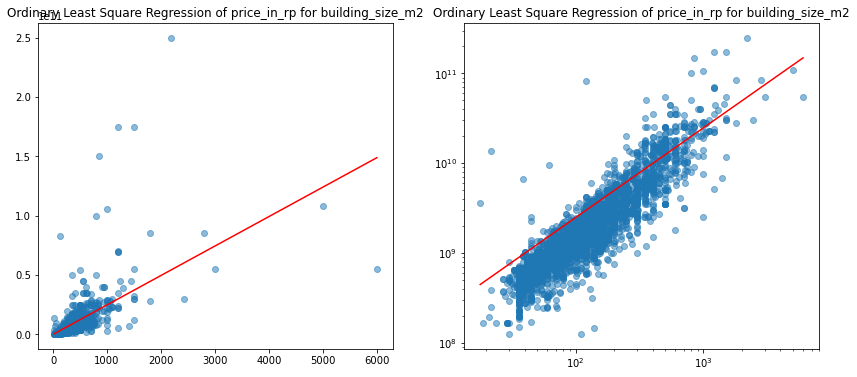

In [4]:
# linear OLS
y_linear = results.predict(X)
# plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for ax_ in ax:
    ax_.scatter(X.building_size_m2, y, alpha=0.5)
    ax_.plot(
        np.sort(X.building_size_m2),
        y_linear[np.argsort(X.building_size_m2)], color='r'
    )
    ax_.set_title('Ordinary Least Square Regression of price_in_rp for building_size_m2')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
 

Note that plot with `log scale axis` explains that linearity exist between our explanatory variable and our target variable, but don't be deceived by its equally spreaded (constance variance) response along the regression line because the actual meaning is that it confirms the response indeed spreads from the regression line as their center.

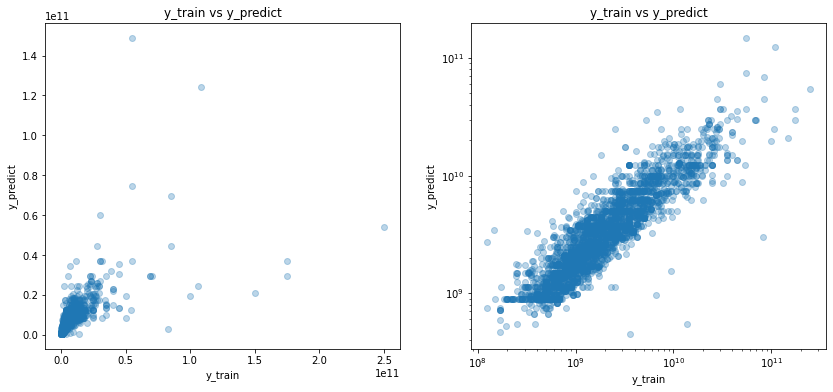

In [5]:
y_predict = results.predict(exog=X).values.reshape(-1, 1)
y = y_train.price_in_rp.values.reshape(-1, 1)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for ax_ in ax:
    ax_.scatter(x=y, y=y_predict, alpha=0.3)
    ax_.set_title('y_train vs y_predict')
    ax_.set_xlabel('y_train')
    ax_.set_ylabel('y_predict')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

#### **Residual Analysis of Simple Linear Regression**

Text(0, 0.5, 'residual')

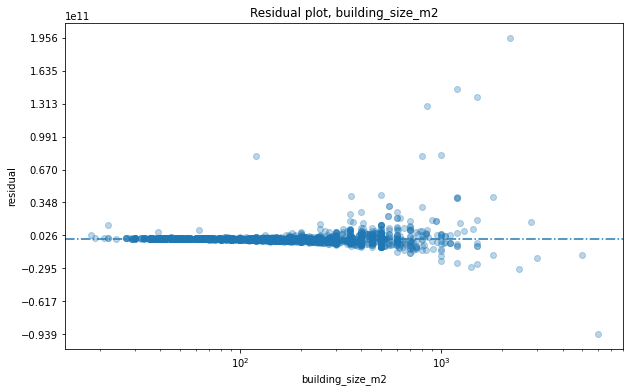

In [6]:
y_predict = results.predict(exog=X).values.reshape(-1, 1)
y = y_train.price_in_rp.values.reshape(-1, 1)
resid = y - y_predict
# matpltlib plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x=X_train.building_size_m2.values.reshape(-1, 1), y=resid, alpha=0.3)
ax.axhline(y=resid.mean(), linestyle='-.')
ax.set_title('Residual plot, building_size_m2')
ax.set_yticks(np.linspace(resid.min(), resid.max(), 10))
ax.set_xscale('log')
ax.set_xlabel('building_size_m2')
ax.set_ylabel('residual')

Text(0, 0.5, 'Residual')

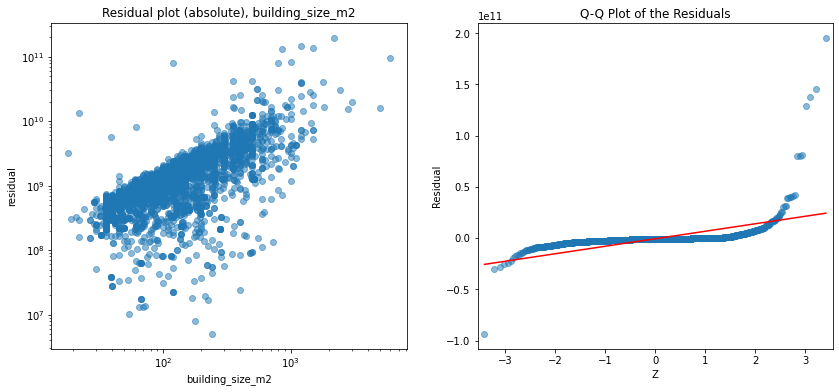

In [7]:
from statsmodels.graphics.gofplots import ProbPlot

# residual plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].scatter(x=X_train.building_size_m2.values.reshape(-1, 1), y=abs(resid), alpha=0.5)
ax[0].set_title('Residual plot (absolute), building_size_m2')
ax[0].set_yticks(np.linspace(resid.min(), resid.max(), 10))
ax[0].set_xscale('log') 
ax[0].set_yscale('log', nonpositive='mask')
ax[0].set_xlabel('building_size_m2')
ax[0].set_ylabel('residual')
# Q-Q Plot
pplot = ProbPlot(resid.flatten())
pplot.qqplot(ax=ax[1], alpha=0.5, line='s')
ax[1].set_title('Q-Q Plot of the Residuals')
ax[1].set_xlabel('Z')
ax[1].set_ylabel('Residual')

In [8]:
from statsmodels.stats.diagnostic import het_breuschpagan

exog_het = X_train['building_size_m2'].values.reshape(-1, 1)
# since auxillary regression of residual 
# must have an intercept constant:
exog_het = add_constant(exog_het) 
lm, lm_pvalue, fvalue, f_pvalue = het_breuschpagan(resid, exog_het, robust=True)
pd.DataFrame({
    'statistic': ['lagrange multiplier', 'f'],
    'statistic_value': [lm, fvalue],
    'p_value': [lm_pvalue, f_pvalue]
    })

,statistic,statistic_value,p_value
0,lagrange multiplier,273.16,0.00
1,f,299.67,0.00


Let's further verify this heteroscedacity condition by inspecting the influence of our observations data. Influence will be inspected using `studentized residual, leverage statistics, and cook's distance`, as of next section.

#### **Outliers Detection: Studentized Residual, Leverage Point, Cook Distance**

Text(0.5, 0, 'building_size_m2')

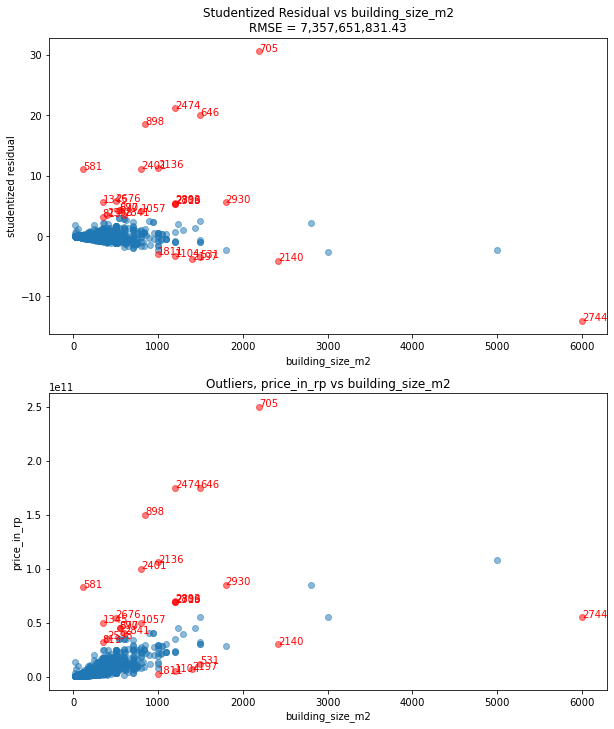

In [9]:
X = X_train['building_size_m2'].values
y = y_train['price_in_rp'].values
lm = OLS(y, X)
results = lm.fit()
y_hat = results.predict(X)
mse = mean_squared_error(y, y_hat)
student_resid = results.outlier_test()[:, 0]
outlier_obs = ((student_resid > 3) | (student_resid < -3))
outlier_obs_index = np.where(outlier_obs)[0]
# plot
fig, ax = plt.subplots(2, 1, figsize=(10, 12))
# Studentized Residual Plot
ax[0].scatter(x=X[~outlier_obs], y=student_resid[~outlier_obs], alpha=0.5)
ax[0].scatter(x=X[outlier_obs], y=student_resid[outlier_obs], alpha=0.5, color='r', label='Outliers')
for x, student_resid, index in np.c_[X[outlier_obs], student_resid[outlier_obs], outlier_obs_index]:
    ax[0].text(x=x, y=student_resid, s=str(int(index)), color='r')
ax[0].set_ylabel('studentized residual')
ax[0].set_xlabel('building_size_m2')
ax[0].set_title(f'Studentized Residual vs building_size_m2\nRMSE = {np.sqrt(mse):,.2f}')
# Observations Plot
ax[1].scatter(x=X[~outlier_obs], y=y[~outlier_obs], alpha=0.5)
ax[1].scatter(x=X[outlier_obs], y=y[outlier_obs], alpha=0.5, color='r', label='Outliers')
for x, y, index in np.c_[X[outlier_obs], y[outlier_obs], outlier_obs_index]:
    ax[1].text(x=x, y=y, s=str(int(index)), color='r')
ax[1].set_title('Outliers, price_in_rp vs building_size_m2')
ax[1].set_ylabel('price_in_rp')
ax[1].set_xlabel('building_size_m2')

Text(0.5, 0, 'building_size_m2')

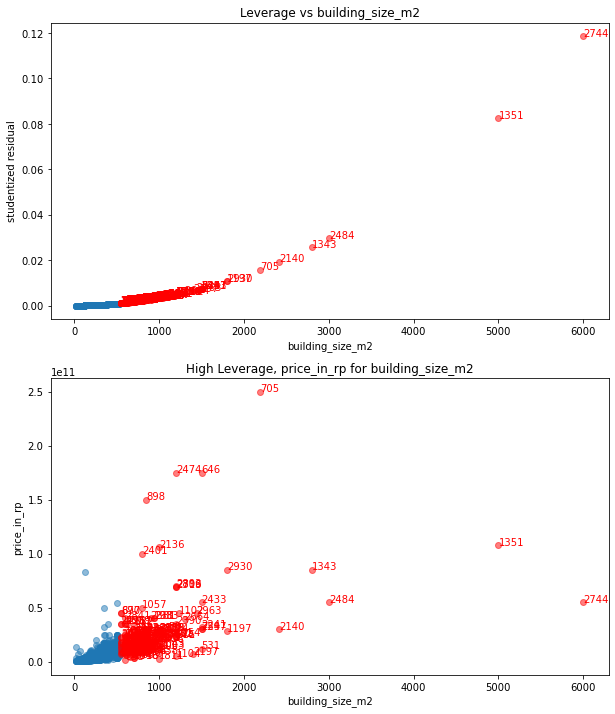

In [10]:
# getting leverage statistics
X = X_train['building_size_m2'].values
y = y_train['price_in_rp'].values
lm = OLS(y, X)
results = lm.fit()
leverage = results.get_influence().hat_matrix_diag
high_leverag_tresh = 3 * (1) / (X.shape[0])
high_leverage_obs = (leverage > high_leverag_tresh)
high_leverage_obs_index = np.where(high_leverage_obs)[0]
# Plot Leverage Statistics
fig, ax = plt.subplots(2, 1, figsize=(10, 12))
ax[0].scatter(
    x=X[~high_leverage_obs], y=leverage[~high_leverage_obs], alpha=0.5)
ax[0].scatter(
    x=X[high_leverage_obs], y=leverage[high_leverage_obs], 
    alpha=0.5, color='r', label='high leverage')
for x, leverage, index in np.c_[X[high_leverage_obs], leverage[high_leverage_obs], high_leverage_obs_index]:
    ax[0].text(x=x, y=leverage, s=str(int(index)), color='r')
ax[0].set_ylabel('studentized residual')
ax[0].set_xlabel('building_size_m2')
ax[0].set_title('Leverage vs building_size_m2')
# Observations Plot
ax[1].scatter(x=X[~high_leverage_obs], y=y[~high_leverage_obs], alpha=0.5)
ax[1].scatter(x=X[high_leverage_obs], y=y[high_leverage_obs], alpha=0.5, color='r', label='Outliers')
for x, y, index in np.c_[X[high_leverage_obs], y[high_leverage_obs], high_leverage_obs_index]:
    ax[1].text(x=x, y=y, s=str(int(index)), color='r')
ax[1].set_title('High Leverage, price_in_rp for building_size_m2')
ax[1].set_ylabel('price_in_rp')
ax[1].set_xlabel('building_size_m2')

Text(0.5, 0, 'building_size_m2')

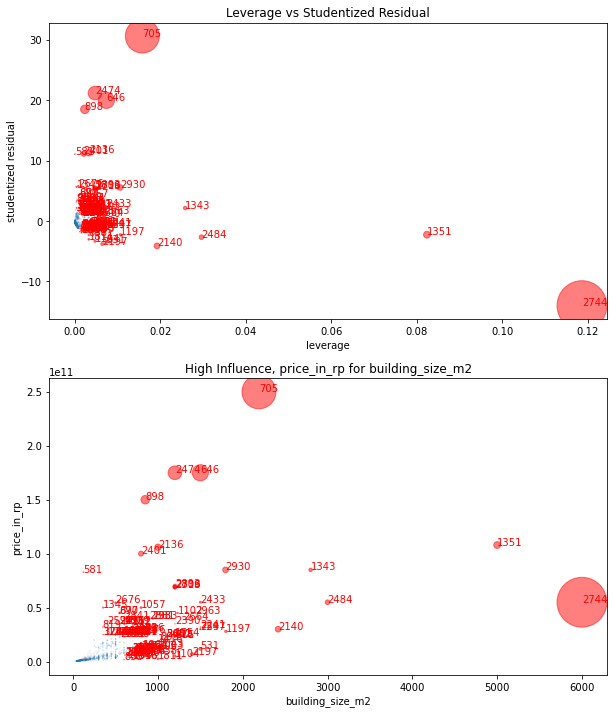

In [11]:
# Cook Distance
X = X_train['building_size_m2'].values
y = y_train['price_in_rp'].values
lm = OLS(y, X)
results = lm.fit()
student_resid = results.outlier_test()[:, 0]
leverage = results.get_influence().hat_matrix_diag
cooks_dist = results.get_influence().cooks_distance[0]
high_influence_obs = (cooks_dist > 4 / (X.shape[0] - 1))
high_influence_obs_index = np.where(high_influence_obs)[0]
# High Influence Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 12))
ax[0].scatter(
    x=leverage[~high_influence_obs], y=student_resid[~high_influence_obs], 
    s= cooks_dist[~high_influence_obs] * 100, alpha=0.5)
ax[0].scatter(
    x=leverage[high_influence_obs], y=student_resid[high_influence_obs], 
    alpha=0.5, color='r', s=cooks_dist[high_influence_obs] * 100,
    label='high influence')
for lev, stud_resid, index in np.c_[
    leverage[high_influence_obs], student_resid[high_influence_obs], high_influence_obs_index]:
    ax[0].text(x=lev, y=stud_resid, s=str(int(index)), color='r')
ax[0].set_ylabel('studentized residual')
ax[0].set_xlabel('leverage')
ax[0].set_title('Leverage vs Studentized Residual')
# Observations Plot
ax[1].scatter(
    x=X[~high_influence_obs], y=y[~high_influence_obs], 
    s=cooks_dist[~high_influence_obs] * 100, alpha=0.5)
ax[1].scatter(
    x=X[high_influence_obs], y=y[high_influence_obs], 
    s=cooks_dist[high_influence_obs] * 100, alpha=0.5, color='r', label='Outliers')
for x, y, index in np.c_[X[high_influence_obs], y[high_influence_obs], high_influence_obs_index]:
    ax[1].text(x=x, y=y, s=str(int(index)), color='r')
ax[1].set_title('High Influence, price_in_rp for building_size_m2')
ax[1].set_ylabel('price_in_rp')
ax[1].set_xlabel('building_size_m2')

In [12]:
X_train.iloc[[11, 493, 581], :16].T

,11,493,581
certificate,shm - sertifikat hak milik,shm - sertifikat hak milik,shm - sertifikat hak milik
property_condition,bagus,baru,butuh renovasi
furnishing,unfurnished,unfurnished,unfurnished
city,Depok,Depok,Jakarta Barat
lat,-6.40,-6.37,-6.20
long,106.77,106.82,106.80
bedrooms,1,2,5
bathrooms,1,1,3
land_size_m2,72.00,46.00,"1,076.00"
building_size_m2,43.00,36.00,120.00


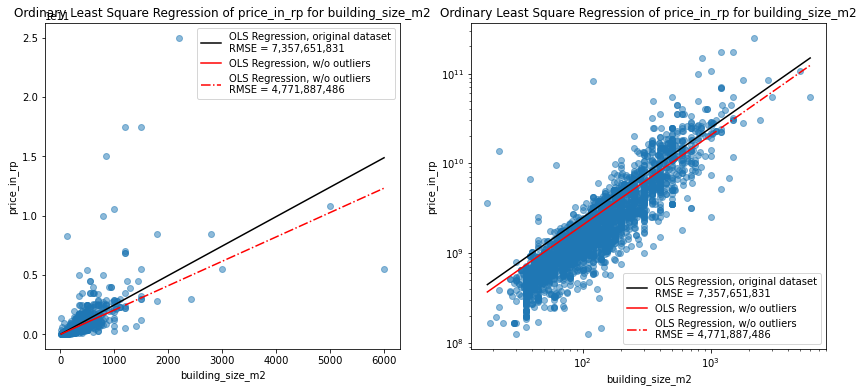

In [13]:
X = X_train['building_size_m2'].values
y = y_train['price_in_rp'].values
lm_1 = OLS(y, X)
lm_2 = OLS(y[~high_influence_obs], X[~high_influence_obs])
prediction_range = np.max(X[~high_influence_obs])
results_1 = lm_1.fit()
results_2 = lm_2.fit()
y_predict_1 = results_1.predict(X)
y_predict_2 = results_2.predict(X[X <= prediction_range])
y_predict_2_extr = results_2.predict(X[X > prediction_range])
mse_1 = mean_squared_error(y, y_predict_1)
mse_2 = mean_squared_error(y[X <= prediction_range], y_predict_2)
# plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for ax_ in ax:
    ax_.scatter(X, y, alpha=0.5)
    ax_.plot(
        np.sort(X),
        y_predict_1[np.argsort(X)], color='black',
        label=f'OLS Regression, original dataset\nRMSE = {np.sqrt(mse_1):,.0f}'       
    )
    ax_.plot(
        np.sort(X[X <= prediction_range]),
        y_predict_2[np.argsort(X[X <= prediction_range])], color='r',
        label='OLS Regression, w/o outliers'
    )
    ax_.plot(
        np.sort(X[X > prediction_range]),
        y_predict_2_extr[np.argsort(X[X > prediction_range])], linestyle='-.', color='r',
        label=f'OLS Regression, w/o outliers\nRMSE = {np.sqrt(mse_2):,.0f}'
    )    
    ax_.set_title('Ordinary Least Square Regression of price_in_rp for building_size_m2')
    ax_.legend()
    ax_.set_xlabel('building_size_m2')
    ax_.set_ylabel('price_in_rp')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

In [14]:
results_2.summary().tables[0]

Dep. Variable:,y,R-squared (uncentered):,0.833
Model:,OLS,Adj. R-squared (uncentered):,0.833
Method:,Least Squares,F-statistic:,1.477e+04
Date:,"Wed, 23 Nov 2022",Prob (F-statistic):,0.00
Time:,00:44:50,Log-Likelihood:,-67590.
No. Observations:,2963,AIC:,1.352e+05
Df Residuals:,2962,BIC:,1.352e+05
Df Model:,1,,
Covariance Type:,nonrobust,,


In [15]:
results_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
x1,2.054e+07,1.69e+05,121.530,0.000,2.02e+07,2.09e+07


#### **Dealing with Non-Constant Variance**

We will use `Weighted OLS` to address non-constant variance in the data. For this dataset, we will use `Regression Robust to Heteroscedacity` provided in `modules` directory, which developed according to Atkinson et al., 2016<sup>[1]</sup>. Sample weight is estimated using parametric formula and iteration algorithm explained in that same scientific journal.

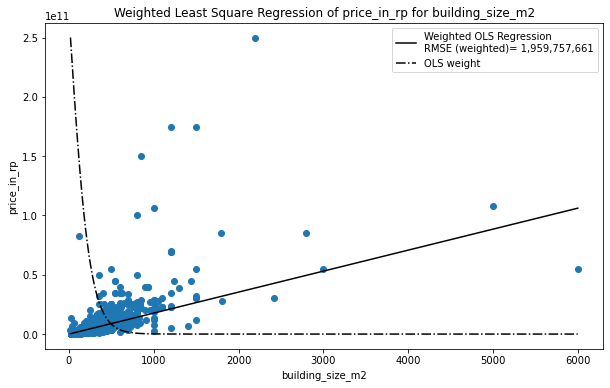

In [16]:
X = X_train['building_size_m2'].values.reshape(-1, 1)
y = y_train['price_in_rp'].values
robust_reg = HetRobustRegression(fit_intercept=False)
# Weighted OLS with full dataset
lm_3a = robust_reg.fit(X, y, X)
y_predict_3a = robust_reg.predict(X)
sample_weight_a = lm_3a.weight_
sample_weight_a_normlzd = \
    (sample_weight_a - np.min(sample_weight_a)) / (np.max(sample_weight_a) - np.min(sample_weight_a))
scaled_weight_a = sample_weight_a_normlzd * np.max(y)
mse_3a = mean_squared_error(y, y_predict_3a, sample_weight=sample_weight_a)
# plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x=X, y=y)
ax.plot(
    np.sort(X.flatten()), 
    y_predict_3a [np.argsort(X.flatten())], color='black',
    label=f'Weighted OLS Regression\nRMSE (weighted)= {np.sqrt(mse_3a):,.0f}',
    )
ax.plot(
    np.sort(X.flatten()), 
    scaled_weight_a[np.argsort(X.flatten())], color='black',
    label='OLS weight', ls='-.'
    )
ax.set_title('Weighted Least Square Regression of price_in_rp for building_size_m2')
ax.set_xlabel('building_size_m2')
ax.set_ylabel('price_in_rp')
ax.legend()

Text(0.5, 0, 'building_size_m2')

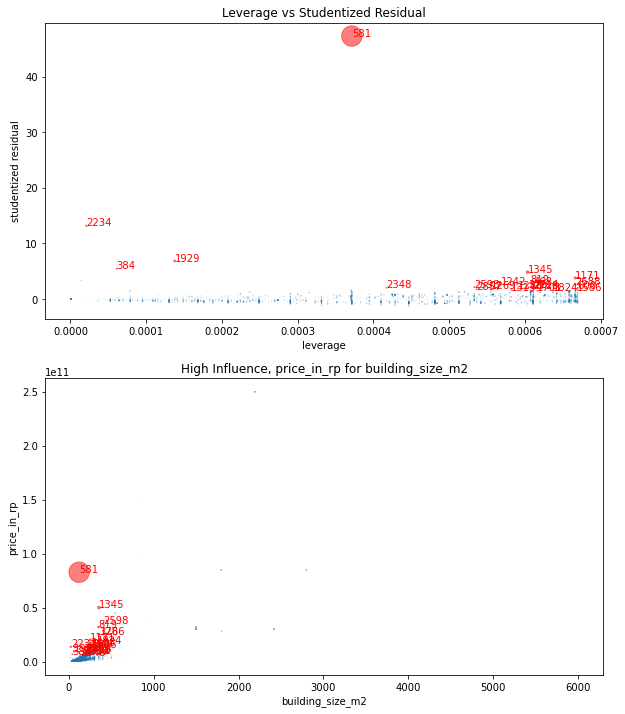

In [17]:
from scipy.sparse import diags

# Cook Distance
X = X_train['building_size_m2'].values.reshape(-1, 1)
y = y_train['price_in_rp'].values
W = diags(sample_weight_a)
p = X.shape[1] # no intercept
resid = sample_weight_a*(y - y_predict_3a)
se2 = np.square(np.linalg.norm(resid)) / (len(y) - p) # se2 = SSE / (n - p), p = 1 since no intercept
h = np.diag(X @ np.linalg.inv((X.T) @ W @ X) @ (X.T) @ W) # leverage is (weighted) hat matrix diagonal
student_resid = resid / np.sqrt(se2 * (1 - h))
cooks_dist = (np.square(resid) / (p * se2)) * (h / np.square(1 - h))
high_influence_obs = (cooks_dist > (4 / (X.shape[0] - p)))
high_influence_obs_index = np.where(high_influence_obs)[0]
# High Influence Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 12))
ax[0].scatter(
    x=h[~high_influence_obs], y=student_resid[~high_influence_obs], 
    s= cooks_dist[~high_influence_obs] * 500, alpha=0.5)
ax[0].scatter(
    x=h[high_influence_obs], y=student_resid[high_influence_obs], 
    alpha=0.5, color='r', s=cooks_dist[high_influence_obs] * 500,
    label='high influence')
for lev, stud_resid, index in np.c_[
    h[high_influence_obs], student_resid[high_influence_obs], high_influence_obs_index]:
    ax[0].text(x=lev, y=stud_resid, s=str(int(index)), color='r')
ax[0].set_ylabel('studentized residual')
ax[0].set_xlabel('leverage')
ax[0].set_title('Leverage vs Studentized Residual')
# Observations Plot
ax[1].scatter(
    x=X[~high_influence_obs], y=y[~high_influence_obs], 
    s=cooks_dist[~high_influence_obs] * 500, alpha=0.5)
ax[1].scatter(
    x=X[high_influence_obs], y=y[high_influence_obs], 
    s=cooks_dist[high_influence_obs] * 500, alpha=0.5, color='r', label='Outliers')
for x, y, index in np.c_[X[high_influence_obs], y[high_influence_obs], high_influence_obs_index]:
    ax[1].text(x=x, y=y, s=str(int(index)), color='r')
ax[1].set_title('High Influence, price_in_rp for building_size_m2')
ax[1].set_ylabel('price_in_rp')
ax[1].set_xlabel('building_size_m2')

Note that our weighted least square doesn't identify larger `building_size_m2` as a high influence, since it already considered them as their weight. The estimator now focuses more closer to higher-weighted samples (i.e. small `building_size_m2`). And also note some of the index that are presented in previous `outliers marker` are also shown in above. 

Let's zoom in onto this range. 

(0.0, 400.0)

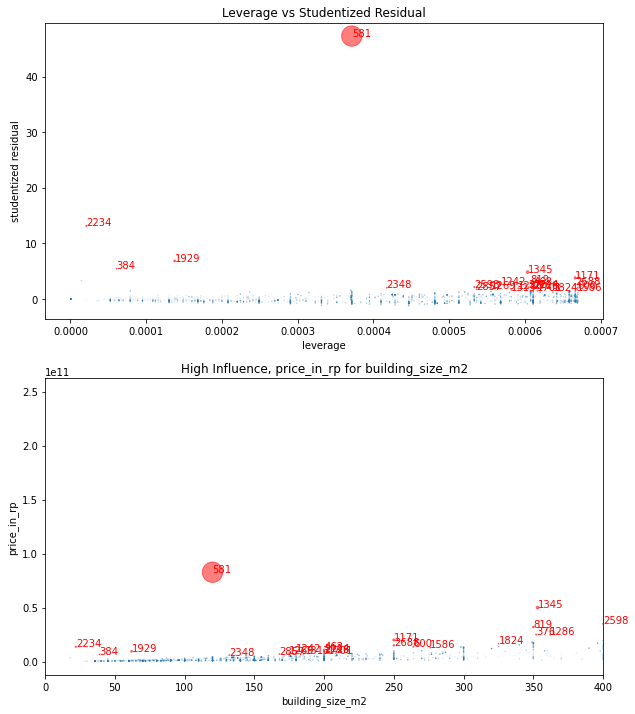

In [18]:
X = X_train['building_size_m2'].values.reshape(-1, 1)
y = y_train['price_in_rp'].values
# High Influence Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 12))
ax[0].scatter(
    x=h[~high_influence_obs], y=student_resid[~high_influence_obs], 
    s= cooks_dist[~high_influence_obs] * 500, alpha=0.5)
ax[0].scatter(
    x=h[high_influence_obs], y=student_resid[high_influence_obs], 
    alpha=0.5, color='r', s=cooks_dist[high_influence_obs] * 500,
    label='high influence')
for lev, stud_resid, index in np.c_[
    h[high_influence_obs], student_resid[high_influence_obs], high_influence_obs_index]:
    ax[0].text(x=lev, y=stud_resid, s=str(int(index)), color='r')
ax[0].set_ylabel('studentized residual')
ax[0].set_xlabel('leverage')
ax[0].set_title('Leverage vs Studentized Residual')
# Observations Plot
ax[1].scatter(
    x=X[~high_influence_obs], y=y[~high_influence_obs], 
    s=cooks_dist[~high_influence_obs] * 500, alpha=0.5)
ax[1].scatter(
    x=X[high_influence_obs], y=y[high_influence_obs], 
    s=cooks_dist[high_influence_obs] * 500, alpha=0.5, color='r', label='Outliers')
for x, y, index in np.c_[X[high_influence_obs], y[high_influence_obs], high_influence_obs_index]:
    ax[1].text(x=x, y=y, s=str(int(index)), color='r')
ax[1].set_title('High Influence, price_in_rp for building_size_m2')
ax[1].set_ylabel('price_in_rp')
ax[1].set_xlabel('building_size_m2')
ax[1].set_xlim(0, 400)

Now let's finalize our model to exclude those high influence observations.

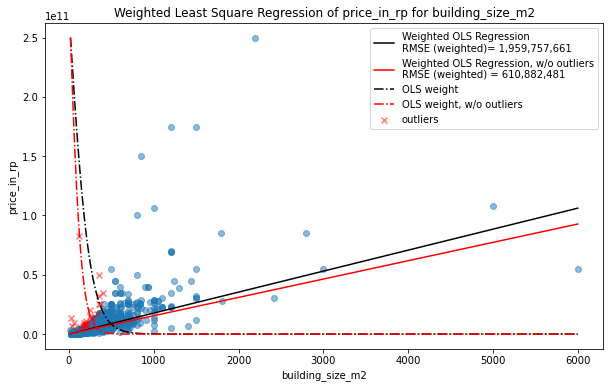

In [19]:
X = X_train['building_size_m2'].values.reshape(-1, 1)
y = y_train['price_in_rp'].values
# Weighted OLS without outliers
lm_3b = robust_reg.fit(X[~high_influence_obs], y[~high_influence_obs], X[~high_influence_obs])
y_predict_3b = robust_reg.predict(X[~high_influence_obs])
sample_weight_b = lm_3b.weight_
sample_weight_b_normlzd = \
    (sample_weight_b - np.min(sample_weight_b)) / (np.max(sample_weight_b) - np.min(sample_weight_b))
scaled_weight_b = sample_weight_b_normlzd * np.max(y)
mse_3b = mean_squared_error(y[~high_influence_obs], y_predict_3b, sample_weight=sample_weight_b)
# plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x=X[~high_influence_obs], y=y[~high_influence_obs], alpha=0.5)
ax.scatter(
    x=X[high_influence_obs], y=y[high_influence_obs], 
    marker='x', color='r',alpha=0.5, label='outliers'
    )
ax.plot(
    np.sort(X.flatten()), 
    y_predict_3a[np.argsort(X.flatten())], color='black',
    label=f'Weighted OLS Regression\nRMSE (weighted)= {np.sqrt(mse_3a):,.0f}',
    )
ax.plot(
    np.sort(X[~high_influence_obs].flatten()), 
    y_predict_3b[np.argsort(X[~high_influence_obs].flatten())], color='red',
    label=f'Weighted OLS Regression, w/o outliers\nRMSE (weighted) = {np.sqrt(mse_3b):,.0f}',
    )
ax.plot(
    np.sort(X.flatten()), 
    scaled_weight_a[np.argsort(X.flatten())], color='black',
    label='OLS weight', ls='-.'
    )
ax.plot(
    np.sort(X[~high_influence_obs].flatten()), 
    scaled_weight_b[np.argsort(X[~high_influence_obs].flatten())], color='red',
    label='OLS weight, w/o outliers', ls='-.'
    )
ax.set_title('Weighted Least Square Regression of price_in_rp for building_size_m2')
ax.set_xlabel('building_size_m2')
ax.set_ylabel('price_in_rp')
ax.legend()

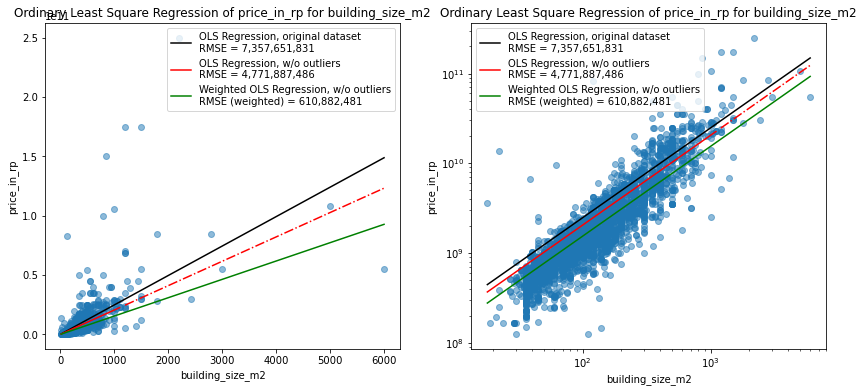

In [20]:
X = X_train['building_size_m2'].values
y = y_train['price_in_rp'].values
# plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for ax_ in ax:
    ax_.scatter(X, y, alpha=0.5)
    ax_.plot(
        np.sort(X),
        y_predict_1[np.argsort(X)], color='black',
        label=f'OLS Regression, original dataset\nRMSE = {np.sqrt(mse_1):,.0f}'       
    )
    ax_.plot(
        np.sort(X[X <= prediction_range]),
        y_predict_2[np.argsort(X[X <= prediction_range])], color='r',
        label=f'OLS Regression, w/o outliers\nRMSE = {np.sqrt(mse_2):,.0f}'
    )
    ax_.plot(
        np.sort(X[X > prediction_range]),
        y_predict_2_extr[np.argsort(X[X > prediction_range])], linestyle='-.', color='r',
    )
    ax_.plot(
        np.sort(X[~high_influence_obs].flatten()), 
        y_predict_3b[np.argsort(X[~high_influence_obs].flatten())], color='green',
        label=f'Weighted OLS Regression, w/o outliers\nRMSE (weighted) = {np.sqrt(mse_3b):,.0f}',
    )  
    ax_.set_title('Ordinary Least Square Regression of price_in_rp for building_size_m2')
    ax_.legend()
    ax_.set_xlabel('building_size_m2')
    ax_.set_ylabel('price_in_rp')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

#### **Inference of `building_size_m2` parameter  and `mean response`**

We are going to use `wild bootstrap` to estimate distribution of `building_size_m2` parameter.

In [21]:
def coefficient(x, y_null, boot_resid):
    epsilon = np.random.choice([1, -1], len(y_null), p=[0.5, 0.5]) # Flachair's pick distribution
    boot_resid_ = boot_resid.flatten()
    resid_dgp = boot_resid_ * epsilon
    y_dgp = (y_null + resid_dgp).flatten()
    lm_boots = OLS(y_dgp, x)
    result_boots = lm_boots.fit()
    coef_boots = result_boots.params[0]
    return coef_boots

X = X_train['building_size_m2'].values.reshape(-1, 1)[~high_influence_obs]
y = y_train['price_in_rp'].values[~high_influence_obs]
# prediction
lm = HetRobustRegression(fit_intercept=False)
results = lm.fit(X, y, X)
y_predict = results.predict(X) # y_predict here serves beta as the null hypotheses for bootstrap
coef = results.coef_
# calculate hat matrix
h = np.diag(X @ np.linalg.inv((X.T) @ X) @ (X.T)) #  = h_t in Flachair (2003)
# calculate adjusted residual
residual = y - y_predict # = OLS restricted residuals in Flachair (2003)
a = 1/ (1 - h) # using HC3 as proposed by Flachair (2003)
resid = a * residual
adj_resid = resid - np.mean(resid)
# bootstrap
arr = np.empty(len(y))
sample = (arr, )
confidence_level = 0.95
lower_tail = (1 - confidence_level) / 2
upper_tail = 1 - lower_tail 
bootstrap_res = bootstrap(
    sample, lambda arr: coefficient(X, y_predict, adj_resid), vectorized=False, 
    confidence_level=confidence_level, method='percentile'
)
pd.DataFrame([
    {'model': 'Weighted OLS, w/o outliers', 
    'coef': coef[0],
    f'ci_low ({lower_tail:.3f})': bootstrap_res.confidence_interval[0],
    f'ci_high({upper_tail:.3f})': bootstrap_res.confidence_interval[1],
    'bootstrap_se': bootstrap_res.standard_error}
    ])

,model,coef,ci_low (0.025),ci_high(0.975),bootstrap_se
0,"Weighted OLS, w/o outliers","15,461,356.16","11,098,839.35","19,816,817.41","2,311,168.50"


Compare it to interval calculated using *student's t distribution* based on standard error of the coefficient:

In [22]:
results_2.summary(alpha=0.05).tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
x1,2.054e+07,1.69e+05,121.530,0.000,2.02e+07,2.09e+07


For large sample, it is known that inference of regression coefficient *using student's t-distribution* will covers the *violation of normality* since *t-distribution will converge to normal*, but we won't know for sure how large of `n sample` is large enough for our dataset. But what is known that the largeness of `n` is highly affected by dataset skewness, in which our dataset suffers highly. Our model with `building_size_m2` also suffers from `non-constant variance`, which also affect the validity of our *t-distribution*.

The confidence interval is quite narrow (compared to the bootstrap result). The safer choice will be the `bootstrap confidence interval` due to reasons above.

As we hope that the bootstrap result portrays the true distribution of coefficient onfidently (we followed wild bootstrap method to achieve unbiased regression DGP and we assume that the dataset covers the population data well enough), the possibility of `building_size_m2` value can be identified by using below bootstrap plot.

Text(0, 0.5, 'coeff value')

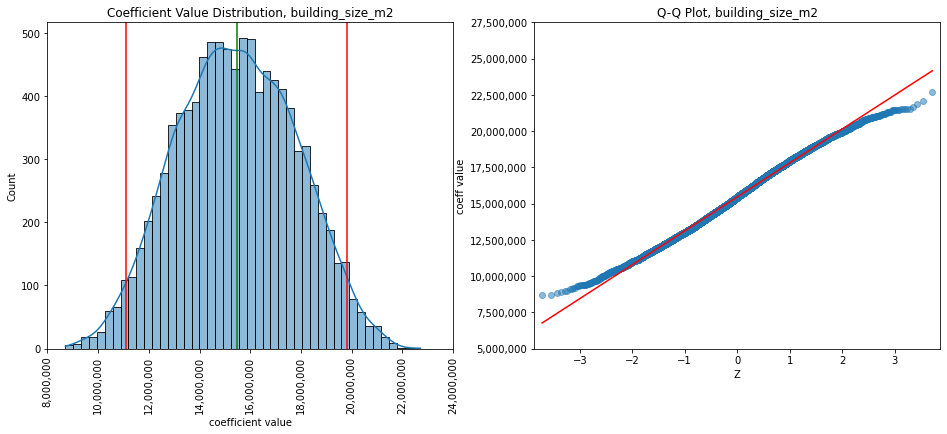

In [23]:
# bootstrapping
n_iter = 9999
arr = np.empty((n_iter, 1))
bootstrap_coeff_value = \
    np.apply_along_axis(lambda x: coefficient(X, y_predict, resid), 1, arr)
# plotting bootstrap result
conf_low = bootstrap_res.confidence_interval[0]
conf_high = bootstrap_res.confidence_interval[1]
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(
    x=bootstrap_coeff_value, kde=True, ax=ax[0]
    )
ax[0].axvline(coef[0], color='g')
ax[0].axvline(conf_low, color='r')
ax[0].axvline(conf_high, color='r')
xticks = ax[0].get_xticks()
ax[0].set_title('Coefficient Value Distribution, building_size_m2')
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(['{:,.0f}'.format(x) for x in xticks], rotation=90)
ax[0].set_xlabel('coefficient value')
# Q-Q Plot
pplot = ProbPlot(bootstrap_coeff_value.flatten())
pplot.qqplot(ax=ax[1], alpha=0.5, line='s')
yticks = ax[1].get_yticks()
ax[1].set_yticks(yticks)
ax[1].set_yticklabels(['{:,.0f}'.format(y) for y in yticks])
ax[1].set_title('Q-Q Plot, building_size_m2')
ax[1].set_xlabel('Z')
ax[1].set_ylabel('coeff value')

As seen above, the coefficient distribution is quite skewed, which not yet close to our `symmetric t-distribution` caused by incorrect t-distribution due to non-constant variance. 

The distribution is also fat-tailed, in which the sample size effect doesn't quite make the distribution *converge to normality* yet.

Both the skewed and fat-tailed distribution will be considered in `BCa Corrected Interval` that has been calculated by using `scipy.stats.bootstrap` program, making the `bootstrap ci` resulting in the more confidence choice of CI calculation.

Since our regression formula `y = 15,461,356.16 * X` here gives `conditional mean of price_price_in_rp at particular building_size_m2: mean y given X=x*`, confidence interval of X parameter will able to provide ` inference of mean y at 95% confidence level`.

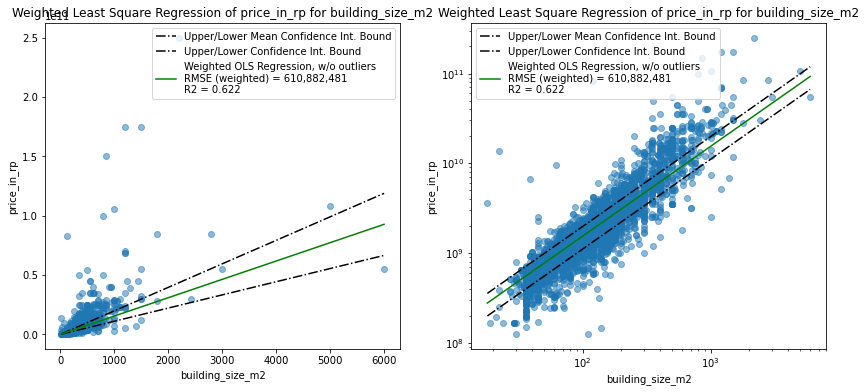

In [24]:
X = X_train['building_size_m2'].values
y = y_train['price_in_rp'].values
low_ci = (X * conf_low)
high_ci = (X * conf_high)
r2 = lm_3b.score(
    X[~high_influence_obs].reshape(-1, 1), 
    y[~high_influence_obs],
    X[~high_influence_obs].reshape(-1, 1))
# plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for ax_ in ax:
    ax_.scatter(X, y, alpha=0.5)
    ax_.plot(
        np.sort(X),
        high_ci[np.argsort(X)], color='black', ls='-.',
        label='Upper/Lower Mean Confidence Int. Bound'       
    )
    ax_.plot(
        np.sort(X),
        low_ci[np.argsort(X)], color='black', ls='-.',
        label='Upper/Lower Confidence Int. Bound'       
    )
    ax_.plot(
        np.sort(X[~high_influence_obs].flatten()), 
        y_predict_3b[np.argsort(X[~high_influence_obs].flatten())], color='green',
        label=\
            'Weighted OLS Regression, w/o outliers'
            f'\nRMSE (weighted) = {np.sqrt(mse_3b):,.0f}'
            f'\nR2 = {r2:.3f}'
    )  
    ax_.set_title('Weighted Least Square Regression of price_in_rp for building_size_m2')
    ax_.legend()
    ax_.set_xlabel('building_size_m2')
    ax_.set_ylabel('price_in_rp')
ax[1].set_xscale('log')
ax[1].set_yscale('log')

#### **Prediction Interval of Simple Regression**

Prediction interval of a linear regression is an interval of plausible values of future Y at a specific value of parameter x*, which accounts for ***variance of mean response Y caused by variability of regression coefficient which accounted in regression model**, and **variability caused by error term which can't be explained in regression model***. 

Recall from previous section, our *R2* value for this model is less than 0.5, explains that there were variability that can't be explained by the simple linear model. Plot of *Y_obs vs Y_predicted* also shows unexplained variance of the response by using only `building_size_m2`.

The error term variability can also be seen in residual plot, where the residual is quite condensed in small `building_size_m2` but continue to spread out in large `building_size_m2` (i.e. indicating non-constant variance).

Theoretical prediction interval of OLS relies heavily on *normality assumption* and *constant variance*, which is violated by our simple linear model.

Let's see the calculated prediction interval by our Simple Linear Model, which is simply calculated by assumming the normality and constant variance is valid.

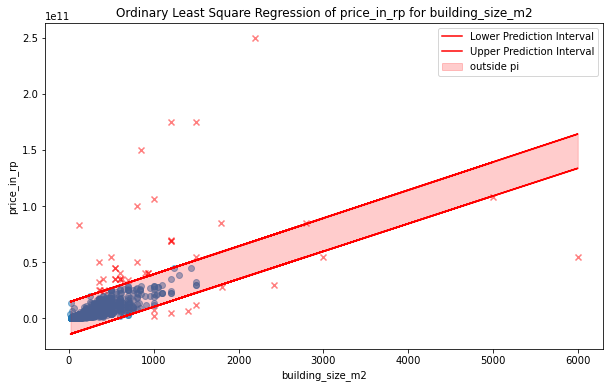

In [25]:
X = X_train['building_size_m2'].values
y = y_train['price_in_rp'].values
lm = OLS(y, X)
results = lm.fit()
y_predict = results.get_prediction(X).summary_frame(0.05)
pi_lower = y_predict.obs_ci_lower
pi_upper = y_predict.obs_ci_upper
outside_pi = np.logical_or(y > pi_upper, y < pi_lower)
# plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(
    x=X[~outside_pi], 
    y=y[~outside_pi], alpha=0.5
    )
ax.scatter(
    x=X[outside_pi], 
    y=y[outside_pi], alpha=0.5,
    color='red', marker='x' 
    )
ax.plot(X, pi_lower, color='r', label='Lower Prediction Interval')
ax.plot(X, pi_upper, color='r', label='Upper Prediction Interval')
ax.fill_between(
    x=np.sort(X), y1=pi_lower[np.argsort(X)], 
    y2=pi_upper[np.argsort(X)], alpha=0.2, color='r',
    label='outside pi'
)
ax.set_xlabel('building_size_m2')
ax.set_ylabel('price_in_rp')
ax.set_title('Ordinary Least Square Regression of price_in_rp for building_size_m2')
ax.legend()
plt.show()

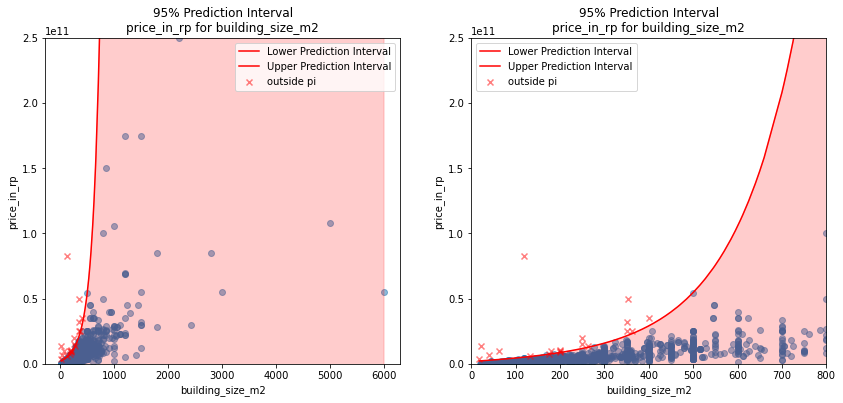

In [26]:
from scipy.stats import norm

X = X_train['building_size_m2'].values.reshape(-1, 1)
y = y_train['price_in_rp'].values
# prediction
lm = HetRobustRegression(fit_intercept=False)
results = lm.fit(X[~high_influence_obs], y[~high_influence_obs], X[~high_influence_obs])
weight = results.get_sample_weight(X)
y_predict = results.predict(X)
resid = np.sqrt(weight) * (y - y_predict) # weighted residual
sigma2 = resid.T @ resid / (X.shape[0] - X.shape[1])
sigma2i = sigma2 * np.power(weight, -1)
interval = norm().interval(0.95)
resid_lower = np.sqrt(sigma2i) * interval[0]
resid_upper = np.sqrt(sigma2i) * interval[1]
pi_lower = y_predict + resid_lower
pi_upper = y_predict + resid_upper
outside_pi = np.logical_or(y >= pi_upper, y <= pi_lower)
# plot
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for ax_ in ax:
    ax_.scatter(
        x=np.sort(X.flatten()[~outside_pi]), 
        y=y[~outside_pi][np.argsort(X.flatten()[~outside_pi])], alpha=0.5
        )
    ax_.scatter(
        x=np.sort(X.flatten()[outside_pi]), 
        y=y[outside_pi][np.argsort(X.flatten()[outside_pi])], alpha=0.5,
        color='red', marker='x', label='outside pi'
        )
    ax_.plot(np.sort(X.flatten()), pi_lower[np.argsort(X.flatten())], color='r', label='Lower Prediction Interval')
    ax_.plot(np.sort(X.flatten()), pi_upper[np.argsort(X.flatten())], color='r', label='Upper Prediction Interval')
    ax_.fill_between(
        x=np.sort(X.flatten()), 
        y1=pi_lower[np.argsort(X.flatten())],
        y2=pi_upper[np.argsort(X.flatten())], 
        alpha=0.2, color='r'
    )
    ax_.set_title('95% Prediction Interval\nprice_in_rp for building_size_m2')
    ax_.set_xlabel('building_size_m2')
    ax_.set_ylabel('price_in_rp')
    ax_.set_ylim(0, np.max(y))
    ax_.legend()
ax[1].set_xlim(0, 800)
plt.show()

#### **Conclusion: Simple Linear Regression**

## 3.2. Multiple Linear Regression

Let's see our base multiple regression using all of the available features. Note that we will use `covariance matrix HC3 that robust to heteroscedacity` to estimate robust standard error. Later we will use `heteroscedacity robust regression` and `wild bootstrap` to further improve our inference performance.

In [27]:
train_set_transfd = pd.merge(
    X_train, y_train, left_index=True, right_index=True
    )
numerical_features = \
    X_train.select_dtypes(exclude=['object', 'category']).drop(['lat', 'long'], axis=1).columns
categorical_features = X_train.select_dtypes(include=['object']).columns
f = 'price_in_rp ~ '\
    + ' + '.join(numerical_features) + ' - 1 + '
f += 'C(certificate, Treatment(reference=3)) + ' # `SHM` as reference
f += 'C(property_condition, Treatment(reference=3)) + ' # `butuh renovasi` as reference
f += 'C(furnishing, Treatment(reference=2)) + '  # `unfurnished` as reference
f += 'C(city, Treatment(reference=0))' # `Bekasi` as reference

lm = OLS.from_formula(f, data=train_set_transfd)
results = lm.fit(cov_type='HC3')

What have we done using above codes?

1. 
2.

Text(0, 0.5, 'residual')

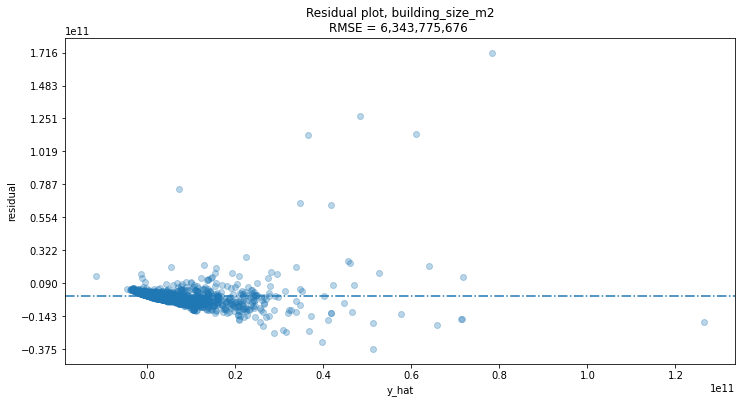

In [28]:
y = y_train.values.flatten()
y_hat = results.predict(train_set_transfd)
resid = train_set_transfd.price_in_rp - y_hat
mse = mean_squared_error(y, y_hat)
# matpltlib plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(x=y_hat, y=resid, alpha=0.3)
ax.axhline(y=resid.mean(), linestyle='-.')
ax.set_title(f'Residual plot, building_size_m2\nRMSE = {np.sqrt(mse):,.0f} ')
ax.set_yticks(np.linspace(resid.min(), resid.max(), 10))
ax.set_xlabel('y_hat')
ax.set_ylabel('residual')

In [29]:
results.summary().tables[0]

Dep. Variable:,price_in_rp,R-squared:,0.594
Model:,OLS,Adj. R-squared:,0.586
Method:,Least Squares,F-statistic:,nan
Date:,"Wed, 23 Nov 2022",Prob (F-statistic):,nan
Time:,00:45:28,Log-Likelihood:,-73600.
No. Observations:,3068,AIC:,1.473e+05
Df Residuals:,3007,BIC:,1.477e+05
Df Model:,60,,
Covariance Type:,HC3,,


In [30]:
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
"C(certificate, Treatment(reference=3))[hgb - hak guna bangunan]",1.207e+09,2.4e+09,0.503,0.615,-3.5e+09,5.92e+09
"C(certificate, Treatment(reference=3))[hp - hak pakai]",1.807e+09,2.47e+09,0.732,0.464,-3.03e+09,6.64e+09
"C(certificate, Treatment(reference=3))[lainnya (ppjb,girik,adat,dll)]",1.946e+09,2.33e+09,0.835,0.404,-2.62e+09,6.51e+09
"C(certificate, Treatment(reference=3))[shm - sertifikat hak milik]",1.857e+09,2.33e+09,0.797,0.425,-2.71e+09,6.42e+09
"C(property_condition, Treatment(reference=3))[T.bagus]",-1.815e+09,2.21e+09,-0.822,0.411,-6.15e+09,2.52e+09
"C(property_condition, Treatment(reference=3))[T.bagus sekali]",-2.871e+09,2.25e+09,-1.277,0.202,-7.28e+09,1.54e+09
"C(property_condition, Treatment(reference=3))[T.baru]",-1.127e+09,2.21e+09,-0.510,0.610,-5.46e+09,3.21e+09
"C(property_condition, Treatment(reference=3))[T.sudah renovasi]",-2.412e+09,2.21e+09,-1.091,0.275,-6.74e+09,1.92e+09
"C(furnishing, Treatment(reference=2))[T.furnished]",-1.496e+08,5.25e+08,-0.285,0.776,-1.18e+09,8.8e+08
"C(furnishing, Treatment(reference=2))[T.semi furnished]",-4.849e+08,4.2e+08,-1.153,0.249,-1.31e+09,3.39e+08


#### **Multicollinearity**

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# We need to encode categorical variable first
dummy_reference = [
    'city_ Bekasi', 'furnishing_unfurnished', 
    'property_condition_butuh renovasi', 'certificate_shm - sertifikat hak milik']
X_train_encoded = \
    pd.get_dummies(X_train, columns=categorical_features)\
        .drop(dummy_reference, axis=1)\
        .drop(['lat', 'long'], axis=1)
X_train_encoded = X_train_encoded
pd.DataFrame({
    'vif': 
        [variance_inflation_factor(X_train_encoded, i) for i in range(X_train_encoded.shape[1])]
    },
    index=X_train_encoded.columns
    ).sort_values(by='vif', ascending=False).T

d:\anaconda3\envs\general_ds\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,fac_gudang,fac_basement,bedrooms,bathrooms,floors,fac_keamanan,property_condition_bagus,fac_garden,property_condition_baru,building_size_m2,maid_bedrooms,maid_bathrooms,electricity_num,fac_jogging_track,carports,city_ Tangerang,garages,fac_ac,city_ Bogor,property_condition_bagus sekali,fac_service_area,fac_lapangan_bulu_tangkis,fac_wastafel,fac_one_gate_system,fac_lapangan_voli,fac_tempat_jemuran,fac_lapangan_basket,fac_kulkas,fac_playground,fac_cctv,fac_jalur_telepon,fac_masjid,fac_lapangan_tenis,fac_water_heater,fac_mesin_cuci,land_size_m2,fac_kitchen_set,fac_kolam_renang,city_ Depok,fac_garasi,fac_tempat_gym,furnishing_semi furnished,fac_akses_parkir,fac_lapangan_bola,city_ Jakarta Selatan,property_condition_sudah renovasi,fac_smart_home,fac_backyard_luas,fac_plumbing_system,city_ Jakarta Barat,city_ Jakarta Utara,furnishing_furnished,"certificate_lainnya (ppjb,girik,adat,dll)",city_ Jakarta Timur,certificate_hgb - hak guna bangunan,fac_kolam_ikan,fac_canopy,city_ Jakarta Pusat,fac_balkon,fac_clubhouse,certificate_hp - hak pakai
vif,inf,inf,26.05,22.67,12.46,9.91,9.53,9.25,8.13,5.65,4.08,4.05,3.77,3.09,2.94,2.92,2.82,2.77,2.67,2.63,2.63,2.63,2.57,2.51,2.51,2.48,2.38,2.29,2.27,2.25,2.24,2.24,2.21,2.20,2.18,2.17,2.17,2.13,2.07,2.03,2.03,1.99,1.99,1.85,1.84,1.79,1.76,1.58,1.56,1.54,1.52,1.33,1.25,1.19,1.16,1.15,1.11,1.10,1.01,1.01,1.01


In [32]:
high_vif_features = [
    'fac_basement', 'fac_gudang', 'bedrooms', 'bathrooms',
    'floors', 'fac_keamanan', 'fac_garden', 
]
dummy_reference = [
    'city_ Bekasi', 'furnishing_unfurnished', 
    'property_condition_butuh renovasi', 'certificate_shm - sertifikat hak milik']
X_train_encoded = \
    pd.get_dummies(X_train, columns=categorical_features)\
        .drop(dummy_reference, axis=1)\
        .drop(['lat', 'long'], axis=1)\
        .drop(high_vif_features, axis=1)
X_train_encoded = X_train_encoded
pd.DataFrame({
    'vif': 
        [variance_inflation_factor(X_train_encoded, i) for i in range(X_train_encoded.shape[1])]
    },
    index=X_train_encoded.columns
    ).sort_values(by='vif', ascending=False).T

,building_size_m2,property_condition_bagus,property_condition_baru,maid_bedrooms,maid_bathrooms,electricity_num,fac_jogging_track,carports,fac_ac,city_ Tangerang,fac_lapangan_bulu_tangkis,fac_wastafel,city_ Bogor,fac_lapangan_voli,fac_one_gate_system,fac_tempat_jemuran,fac_lapangan_basket,fac_kulkas,fac_playground,fac_jalur_telepon,fac_cctv,garages,fac_lapangan_tenis,fac_water_heater,fac_masjid,fac_mesin_cuci,fac_kitchen_set,land_size_m2,fac_kolam_renang,fac_tempat_gym,furnishing_semi furnished,fac_akses_parkir,city_ Depok,property_condition_bagus sekali,fac_lapangan_bola,city_ Jakarta Selatan,fac_smart_home,fac_service_area,fac_backyard_luas,city_ Jakarta Utara,city_ Jakarta Barat,fac_plumbing_system,fac_garasi,property_condition_sudah renovasi,furnishing_furnished,"certificate_lainnya (ppjb,girik,adat,dll)",city_ Jakarta Timur,certificate_hgb - hak guna bangunan,fac_kolam_ikan,fac_canopy,city_ Jakarta Pusat,fac_balkon,fac_clubhouse,certificate_hp - hak pakai
vif,4.91,4.21,4.17,4.03,4.01,3.72,2.94,2.87,2.77,2.71,2.63,2.56,2.52,2.51,2.50,2.47,2.37,2.29,2.27,2.23,2.23,2.20,2.20,2.19,2.18,2.18,2.16,2.12,2.11,2.02,1.98,1.98,1.96,1.87,1.85,1.81,1.73,1.59,1.57,1.46,1.43,1.41,1.41,1.31,1.30,1.24,1.16,1.16,1.15,1.09,1.08,1.01,1.01,1.01


In [33]:
high_vif_features = [
    'fac_basement', 'fac_gudang', 'bedrooms', 'bathrooms',
    'floors', 'fac_keamanan', 'fac_garden', 'lat', 'long'
]
numerical_features = \
    X_train.select_dtypes(exclude=['object', 'category']).drop(high_vif_features, axis=1).columns
f = 'price_in_rp ~ '\
    + ' + '.join(numerical_features) + ' - 1 + '
f += 'C(certificate, Treatment(reference=3)) + ' # `SHM` as reference
f += 'C(property_condition, Treatment(reference=3)) + ' # `butuh renovasi` as reference
f += 'C(furnishing, Treatment(reference=2)) + '  # `unfurnished` as reference
f += 'C(city, Treatment(reference=0))' # `Bekasi` as reference

lm = OLS.from_formula(f, data=train_set_transfd)
results = lm.fit(cov_type='HC3')

#### **Features Significancy**

In [34]:
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
"C(certificate, Treatment(reference=3))[hgb - hak guna bangunan]",-6.036e+08,2.35e+09,-0.257,0.798,-5.21e+09,4.01e+09
"C(certificate, Treatment(reference=3))[hp - hak pakai]",1.515e+09,2.44e+09,0.621,0.535,-3.27e+09,6.3e+09
"C(certificate, Treatment(reference=3))[lainnya (ppjb,girik,adat,dll)]",-1.164e+08,2.24e+09,-0.052,0.959,-4.52e+09,4.28e+09
"C(certificate, Treatment(reference=3))[shm - sertifikat hak milik]",7.498e+07,2.27e+09,0.033,0.974,-4.37e+09,4.52e+09
"C(property_condition, Treatment(reference=3))[T.bagus]",-2.404e+09,2.22e+09,-1.083,0.279,-6.76e+09,1.95e+09
"C(property_condition, Treatment(reference=3))[T.bagus sekali]",-3.544e+09,2.29e+09,-1.549,0.121,-8.03e+09,9.41e+08
"C(property_condition, Treatment(reference=3))[T.baru]",-1.948e+09,2.23e+09,-0.874,0.382,-6.32e+09,2.42e+09
"C(property_condition, Treatment(reference=3))[T.sudah renovasi]",-3.055e+09,2.23e+09,-1.371,0.170,-7.42e+09,1.31e+09
"C(furnishing, Treatment(reference=2))[T.furnished]",-1.088e+09,6.62e+08,-1.643,0.100,-2.39e+09,2.1e+08
"C(furnishing, Treatment(reference=2))[T.semi furnished]",-7.325e+08,4.42e+08,-1.657,0.097,-1.6e+09,1.34e+08


Let's observe above output:
1. `Certificate` features has a high p-value, meaning that there is no significance evidence that `price_in_rp` will be associated with different type of certificate. It is also identified for `property_condition` and `furnishing` parameter. This proves our point in previous chapter.
2. `maid_bedrooms` has a low p-value but gives a high coefficient value since it is inflated by observations with high `price_in_rp` (larger house tends to provide maid_bedrooms). While this condition is proven by our data, however it is less essential to be our main parameter for generalization since it is biased only for large house so I just drop this features.
3. We expect positive values for `facilities` parameters. However some of them has negative value, means that they only `adjusting` for other parameters since it is lacking of coverage along overall price range. This will reduce our generalization so I will drop those parameters. For `positive coefficient value` of other facilities : [`fac_kolam_renang`, `fac_akses_parkir`, `fac_canopy`], we will keep that and let's see how they will be adjusted after other coefficient primary.
4. `Jakarta Utara` has a significantly high coefficient value, but its p-value is also high. Recall from previous chapter, `Jakarta Utara` is among the highest median of all DKI Jakarta and has a narrow confidence interval (unlike `Jakarta Pusat` which has large spread!). We will keep this feature first and let's see how this feature change if we adjust other features 
5. If we put `Bekasi` as the reference, as of previous chapter `Tangerang` has significantly higher median price than `Bekasi`. It is strange that the coefficient value is negative. Let's keep this city first. 
6. For other features that has high pvalue will be dropped.

In [35]:
from patsy import dmatrices

high_pvalue_features = [
    'fac_tempat_jemuran', 'fac_jogging_track', 'fac_jalur_telepon', 'fac_jogging_track', 'fac_masjid', 
    'fac_cctv', 'fac_kitchen_set', 'fac_playground', 'fac_wastafel', 'fac_ac', 'fac_lapangan_bola', 
    'fac_mesin_cuci', 'fac_lapangan_bulu_tangkis', 'fac_kulkas', 'fac_water_heater', 'fac_smart_home', 
    'fac_backyard_luas', 'fac_garasi', 'fac_balkon', 'fac_clubhouse', 'fac_service_area', 'fac_plumbing_system',
    'maid_bathrooms', 'maid_bedrooms'
]
noise_features = [
    'fac_one_gate_system', 'fac_tempat_gym', 'fac_kolam_ikan', 'fac_lapangan_voli', 'carports', 'garages',
    'fac_lapangan_basket', 'fac_lapangan_tenis', 'fac_akses_parkir', 'fac_canopy'
]
numerical_features = \
    X_train.select_dtypes(exclude=['object', 'category'])\
        .drop(high_vif_features, axis=1)\
        .drop(high_pvalue_features, axis=1)\
        .drop(noise_features, axis=1).columns
f = 'price_in_rp ~ ' + ' + '.join(numerical_features) + ' - 1 + '
f += 'C(city)' # `Bekasi` as reference
y, X = dmatrices(f, train_set_transfd, return_type='dataframe')
X.drop(X.columns[[0, 1, 2, 3, 6]], axis=1, inplace=True)
y = y.values.flatten()
lm = OLS(y, X)
results = lm.fit(cov_type='HC3')
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
C(city)[ Jakarta Pusat],1.186e+10,4.07e+09,2.915,0.004,3.89e+09,1.98e+10
C(city)[ Jakarta Selatan],4.461e+09,1.09e+09,4.088,0.000,2.32e+09,6.6e+09
C(city)[ Jakarta Utara],2.021e+09,1.29e+09,1.566,0.117,-5.09e+08,4.55e+09
C(city)[ Tangerang],-1.121e+09,3.81e+08,-2.939,0.003,-1.87e+09,-3.73e+08
land_size_m2,4.396e+06,2.43e+06,1.810,0.070,-3.64e+05,9.16e+06
building_size_m2,1.57e+07,4.11e+06,3.816,0.000,7.63e+06,2.38e+07
electricity_num,2.833e+05,2.28e+05,1.242,0.214,-1.64e+05,7.31e+05
fac_kolam_renang,4.166e+08,3.02e+08,1.377,0.168,-1.76e+08,1.01e+09


Facilities `fac_kolam_renang` now has a high p-value, and other facilities now has negative coefficient, suggesting observation noise. We will drop this features.

In [36]:
high_pvalue_features = [
    'fac_tempat_jemuran', 'fac_jogging_track', 'fac_jalur_telepon', 'fac_jogging_track', 'fac_masjid', 
    'fac_cctv', 'fac_kitchen_set', 'fac_playground', 'fac_wastafel', 'fac_ac', 'fac_lapangan_bola', 
    'fac_mesin_cuci', 'fac_lapangan_bulu_tangkis', 'fac_kulkas', 'fac_water_heater', 'fac_smart_home', 
    'fac_backyard_luas', 'fac_garasi', 'fac_balkon', 'fac_clubhouse', 'fac_service_area', 'fac_plumbing_system',
    'maid_bathrooms', 'maid_bedrooms', 'fac_kolam_renang', 'electricity_num'
]
noise_features = [
    'fac_one_gate_system', 'fac_tempat_gym', 'fac_kolam_ikan', 'fac_lapangan_voli', 'carports', 'garages',
    'fac_lapangan_basket', 'fac_lapangan_tenis', 'fac_akses_parkir', 'fac_canopy'
]
numerical_features = \
    X_train.select_dtypes(exclude=['object', 'category'])\
        .drop(high_vif_features, axis=1)\
        .drop(high_pvalue_features, axis=1)\
        .drop(noise_features, axis=1).columns
f = 'price_in_rp ~ ' + ' + '.join(numerical_features) + ' - 1 + '
f += 'C(city)' # `Bekasi` as reference
y, X = dmatrices(f, train_set_transfd, return_type='dataframe')
X.drop(X.columns[[0, 1, 2, 3, 4, 6]], axis=1, inplace=True)
features = X.columns
y = y.values.flatten()
lm = OLS(y, X)
results = lm.fit(cov_type='HC3')
results.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
C(city)[ Jakarta Selatan],5.321e+09,1.3e+09,4.089,0.000,2.77e+09,7.87e+09
C(city)[ Jakarta Utara],2.391e+09,1.66e+09,1.444,0.149,-8.55e+08,5.64e+09
C(city)[ Tangerang],-6.219e+08,4.96e+08,-1.253,0.210,-1.59e+09,3.51e+08
land_size_m2,4.883e+06,2.44e+06,2.002,0.045,1.03e+05,9.66e+06
building_size_m2,1.871e+07,3.69e+06,5.075,0.000,1.15e+07,2.59e+07


Surprisingly `Jakarta Utara` now becomes significant! But recall from previous chapter, we still has doubt for `Jakarta Pusat` since it has a large spread of median interval (covering almost entire length of price range thus high variability). We will investigate this later. 

In [37]:
results.summary().tables[0]

Dep. Variable:,y,R-squared (uncentered):,0.569
Model:,OLS,Adj. R-squared (uncentered):,0.568
Method:,Least Squares,F-statistic:,510.2
Date:,"Wed, 23 Nov 2022",Prob (F-statistic):,0.00
Time:,00:45:37,Log-Likelihood:,-73922.
No. Observations:,3068,AIC:,1.479e+05
Df Residuals:,3063,BIC:,1.479e+05
Df Model:,5,,
Covariance Type:,HC3,,


Text(0, 0.5, 'residual')

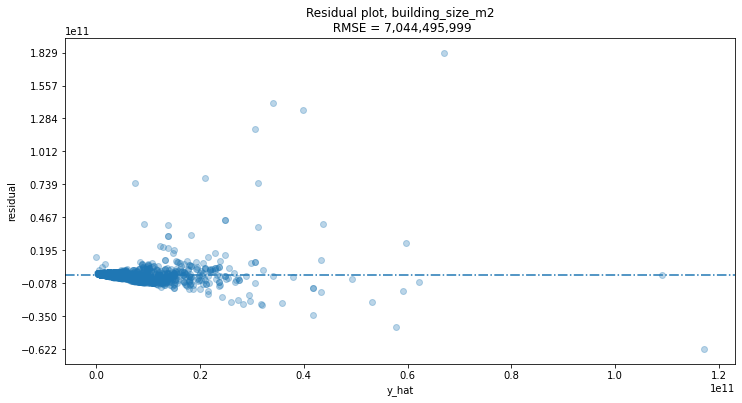

In [38]:
y_hat = results.predict(X).values
resid = y - y_hat
mse = mean_squared_error(y, y_hat)
# matpltlib plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(x=y_hat, y=resid, alpha=0.3)
ax.axhline(y=resid.mean(), linestyle='-.')
ax.set_title(f'Residual plot, building_size_m2\n RMSE = {np.sqrt(mse):,.0f}')
ax.set_yticks(np.linspace(resid.min(), resid.max(), 10))
ax.set_xlabel('y_hat')
ax.set_ylabel('residual')

#### **Addressing Non-Linearity of Multiple Regression**

Text(0, 0.5, 'residual')

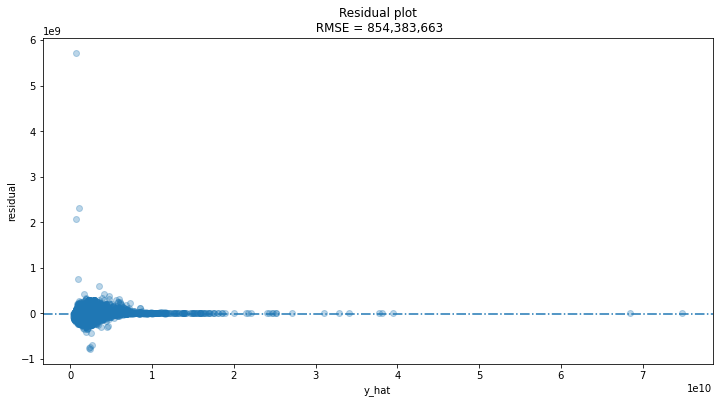

In [39]:
X = X.values
Z = X[:, [3, 4]]# Variables responsible for heteroscedacity
# Robust Regression
reg = HetRobustRegression(fit_intercept=False)
results = reg.fit(X, y, Z)
y_hat = results.predict(X)
weight = results.weight_
weighted_resid = weight * (y - y_hat)
mse = mean_squared_error(y, y_hat, sample_weight=weight)
# matpltlib plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(x=y_hat, y=weighted_resid, alpha=0.3)
ax.axhline(y=weighted_resid.mean(), linestyle='-.')
ax.set_title(f'Residual plot\n RMSE = {np.sqrt(mse):,.0f}')
ax.set_xlabel('y_hat')
ax.set_ylabel('residual')

Text(0.5, 0, 'Obs. Number')

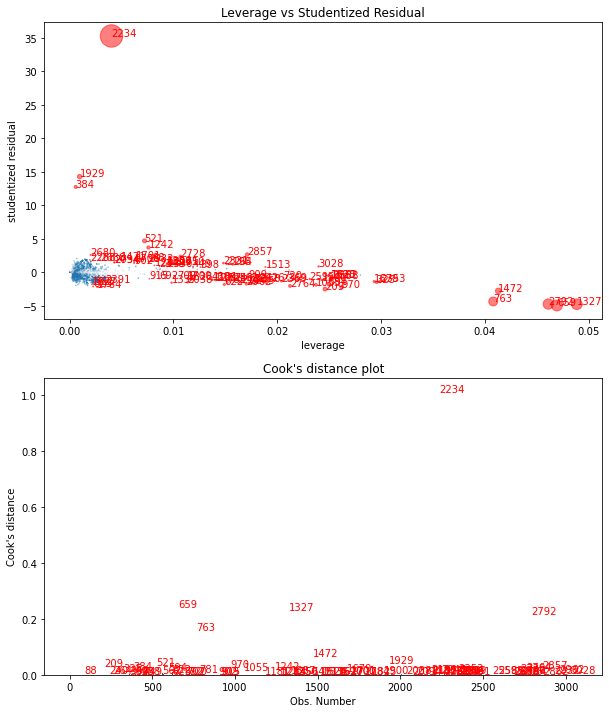

In [40]:
# Cook Distance
W = diags(weight)
p = X.shape[1] # no intercept
resid = weighted_resid
se2 = np.square(np.linalg.norm(resid)) / (len(y) - p) # se2 = SSE / (n - p), p = 1 since no intercept
h = np.diag(X @ np.linalg.inv((X.T) @ W @ X) @ (X.T) @ W) # leverage is (weighted) hat matrix diagonal
student_resid = resid / np.sqrt(se2 * (1 - h))
cooks_dist = (np.square(resid) / (p * se2)) * (h / np.square(1 - h))
high_influence_obs = (cooks_dist > (4 / (X.shape[0] - p)))
high_influence_obs_index = np.where(high_influence_obs)[0]
# High Influence Plot
fig, ax = plt.subplots(2, 1, figsize=(10, 12))
ax[0].scatter(
    x=h[~high_influence_obs], y=student_resid[~high_influence_obs], 
    s= cooks_dist[~high_influence_obs] * 500, alpha=0.5)
ax[0].scatter(
    x=h[high_influence_obs], y=student_resid[high_influence_obs], 
    alpha=0.5, color='r', s=cooks_dist[high_influence_obs] * 500,
    label='high influence')
for lev, stud_resid, index in np.c_[
    h[high_influence_obs], student_resid[high_influence_obs], high_influence_obs_index]:
    ax[0].text(x=lev, y=stud_resid, s=str(int(index)), color='r')
ax[0].set_ylabel('studentized residual')
ax[0].set_xlabel('leverage')
ax[0].set_title('Leverage vs Studentized Residual')
# Cook's distance Plot
obs_index = np.where(y)[0]
ax[1].bar(
    x=obs_index[~high_influence_obs], height=cooks_dist[~high_influence_obs])
ax[1].bar(
    x=obs_index[high_influence_obs], height=cooks_dist[high_influence_obs], 
    color='r', label='Outliers')
for x_, y_ in np.c_[obs_index[high_influence_obs], cooks_dist[high_influence_obs]]:
    ax[1].text(x=x_, y=y_, s=str(int(x_)), color='r')
ax[1].set_title('Cook\'s distance plot')
ax[1].set_ylabel('Cook\'s distance')
ax[1].set_xlabel('Obs. Number')

(0.0, 10000000000.0)

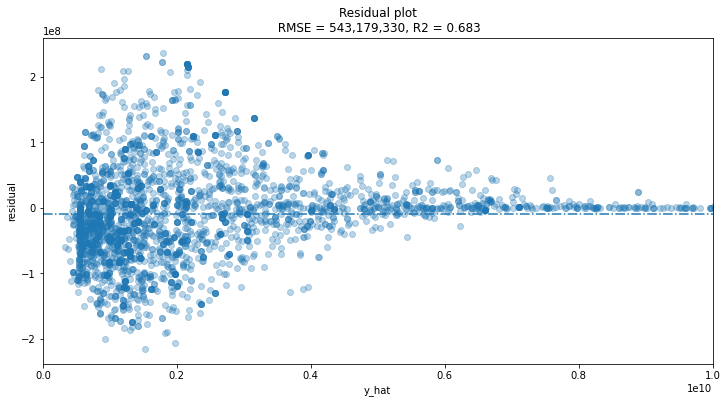

In [41]:
X = X[~high_influence_obs, :]
y = y[~high_influence_obs]
Z = X[:, [3, 4]] # Variables responsible for heteroscedacity
# Robust Regression
reg = HetRobustRegression(fit_intercept=False)
results = reg.fit(X, y, Z)
r2 = results.score(X, y, Z)
y_hat = results.predict(X)
weight = results.weight_
weighted_resid = weight * (y - y_hat)
mse = mean_squared_error(y, y_hat, sample_weight=weight)
# matpltlib plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(x=y_hat, y=weighted_resid, alpha=0.3)
ax.axhline(y=weighted_resid.mean(), linestyle='-.')
ax.set_title(f'Residual plot\n RMSE = {np.sqrt(mse):,.0f}, R2 = {r2:.3f}')
ax.set_xlabel('y_hat')
ax.set_ylabel('residual')
ax.set_xlim(0, 1e10)

Next, we will verify the confidence interval of regression coefficient.

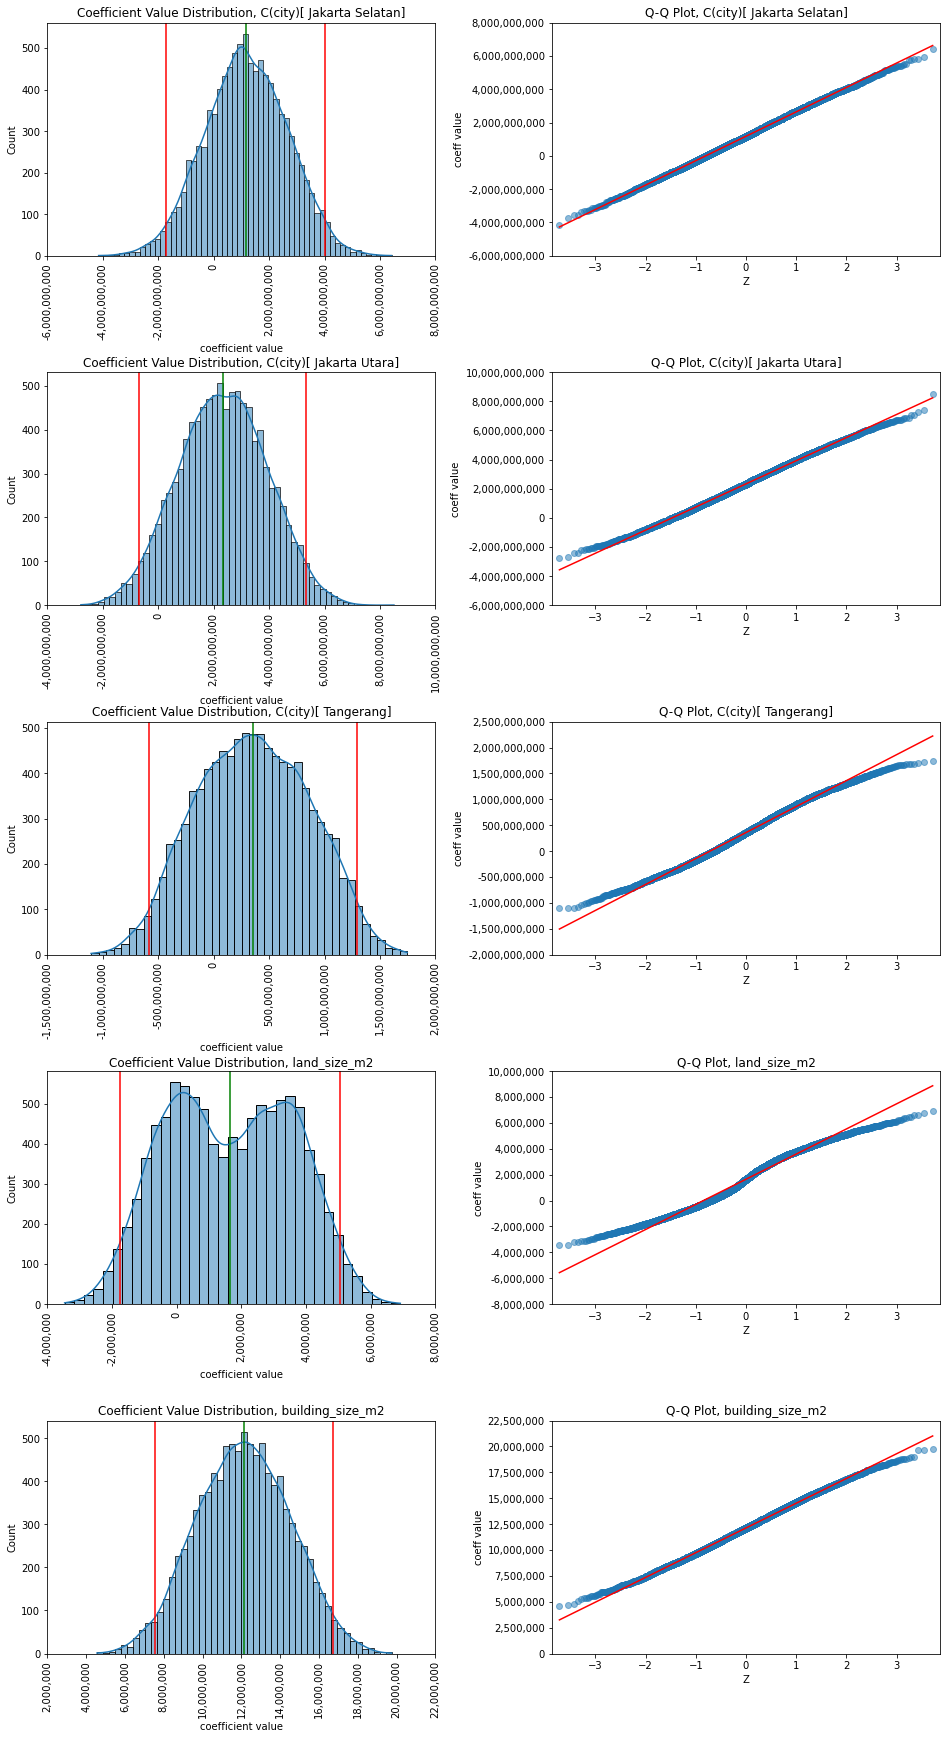

In [42]:
from sklearn.linear_model import LinearRegression
from joblib import dump, load


def coefficient(x, y_null, boot_resid):
    epsilon = np.random.choice([1, -1], len(y_null), p=[0.5, 0.5]) # Flachair's pick distribution
    boot_resid_ = boot_resid.flatten()
    resid_dgp = boot_resid_ * epsilon
    y_dgp = (y_null + resid_dgp).flatten()
    lm_boots = LinearRegression(fit_intercept=False)
    result_boots = lm_boots.fit(x, y_dgp)
    coef_boots = result_boots.coef_
    return coef_boots

# prediction
lm = HetRobustRegression(fit_intercept=False)
results = lm.fit(X, y, Z)
dump(results, 'modules\\fitted_regressor.joblib') # store fitted regressor
y_predict = results.predict(X) # y_predict here serves beta as the null hypotheses for bootstrap
coef = results.coef_
# calculate hat matrix
h = np.diag(X @ np.linalg.inv((X.T) @ X) @ (X.T)) #  = h_t in Flachair (2003)
# calculate adjusted residual
residual = y - y_predict # = OLS restricted residuals in Flachair (2003)
a = 1/ (1 - h) # using HC3 as proposed by Flachair (2003)
resid = a * residual
adj_resid = resid - np.mean(resid)
# bootstrap ci
arr = np.empty(len(y))
sample = (arr, )
confidence_level = 0.95
lower_tail = (1 - confidence_level) / 2
upper_tail = 1 - lower_tail 
bootstrap_res = bootstrap(
    sample, lambda arr: coefficient(X, y_predict, adj_resid), vectorized=False, 
    confidence_level=confidence_level, method='percentile', n_resamples=29999
)
# Features
coef = coef.reshape(-1, 1)
features_name = features.values.reshape(-1, 1)
p = len(features_name)
# bootstrapping distribution
n_iter = 9999
arr = np.empty((n_iter, 1))
bootstrap_coeff_value = \
    np.apply_along_axis(lambda x: coefficient(X, y_predict, adj_resid), 1, arr)
# plotting bootstrap result
conf_low = bootstrap_res.confidence_interval[0].reshape(-1, 1)
conf_high = bootstrap_res.confidence_interval[1].reshape(-1, 1)
coef_array = np.c_[features_name, coef, conf_low, conf_high]
fig, ax = plt.subplots(p, 2, figsize=(16, 6 * p))

for index, (feature, coef, ci_l, ci_h) in enumerate(coef_array):
    sns.histplot(
        x=bootstrap_coeff_value[:, index], kde=True, ax=ax[index, 0]
        )
    ax[index, 0].axvline(coef, color='green')
    ax[index, 0].axvline(ci_l, color='r')
    ax[index, 0].axvline(ci_h, color='r')
    xticks = ax[index, 0].get_xticks()
    ax[index, 0].set_title(f'Coefficient Value Distribution, {feature}')
    ax[index, 0].set_xticks(xticks)
    ax[index, 0].set_xticklabels(['{:,.0f}'.format(x) for x in xticks], rotation=90)
    ax[index, 0].set_xlabel('coefficient value')
    # Q-Q Plot
    pplot = ProbPlot(bootstrap_coeff_value[:, index].flatten())
    pplot.qqplot(ax=ax[index, 1], alpha=0.5, line='s')
    yticks = ax[index, 1].get_yticks()
    ax[index, 1].set_yticks(yticks)
    ax[index, 1].set_yticklabels(['{:,.0f}'.format(y) for y in yticks])
    ax[index, 1].set_title(f'Q-Q Plot, {feature}')
    ax[index, 1].set_xlabel('Z')
    ax[index, 1].set_ylabel('coeff value')
plt.subplots_adjust(wspace=0.3, hspace=0.5)

So far, our weighted multiple regression parameters are explained as below:

In [43]:
pd.DataFrame(
    coef_array,
    columns=['features_name', 'coef', 'conf_low', 'conf_high']
    ).set_index('features_name')

,coef,conf_low,conf_high
features_name,,,
C(city)[ Jakarta Selatan],"1,169,842,676.34","-1,702,166,959.35","4,031,624,537.37"
C(city)[ Jakarta Utara],"2,329,503,679.48","-692,886,760.49","5,341,056,196.03"
C(city)[ Tangerang],"356,120,481.11","-587,185,466.83","1,295,754,855.36"
land_size_m2,"1,649,567.09","-1,745,014.01","5,044,805.40"
building_size_m2,"12,138,296.57","7,541,802.26","16,731,832.84"


# 3. Predictive Performance of Linear Model

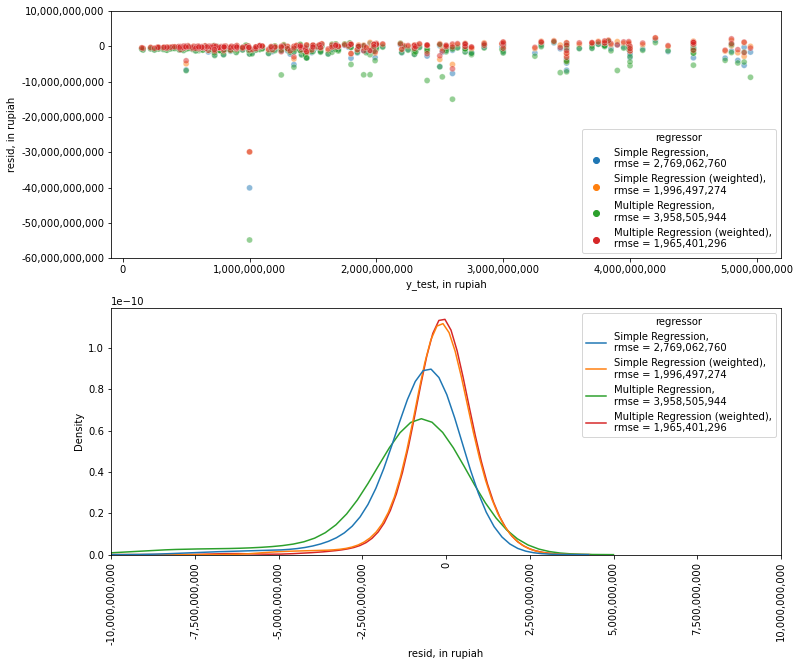

In [44]:
from patsy import dmatrix
import seaborn as sns

def transform_set(X):
    high_pvalue_features = [
        'fac_tempat_jemuran', 'fac_jogging_track', 'fac_jalur_telepon', 'fac_jogging_track', 'fac_masjid', 
        'fac_cctv', 'fac_kitchen_set', 'fac_playground', 'fac_wastafel', 'fac_ac', 'fac_lapangan_bola', 
        'fac_mesin_cuci', 'fac_lapangan_bulu_tangkis', 'fac_kulkas', 'fac_water_heater', 'fac_smart_home', 
        'fac_backyard_luas', 'fac_garasi', 'fac_balkon', 'fac_clubhouse', 'fac_service_area', 'fac_plumbing_system',
        'maid_bathrooms', 'maid_bedrooms', 'fac_kolam_renang', 'electricity_num'
        ]
    noise_features = [
        'fac_one_gate_system', 'fac_tempat_gym', 'fac_kolam_ikan', 'fac_lapangan_voli', 'carports', 'garages',
        'fac_lapangan_basket', 'fac_lapangan_tenis', 'fac_akses_parkir', 'fac_canopy'
        ]
    numerical_features = \
        X_train.select_dtypes(exclude=['object', 'category'])\
            .drop(high_vif_features, axis=1)\
            .drop(high_pvalue_features, axis=1)\
            .drop(noise_features, axis=1).columns
    f = ' + '.join(numerical_features) + ' - 1 + '
    f += 'C(city)' # `Bekasi` as reference
    X_transfd = dmatrix(f, X, return_type='dataframe')
    X_transfd.drop(X_transfd.columns[[0, 1, 2, 3, 4, 6]], axis=1, inplace=True)
    return X_transfd

y_test = pd.read_csv('Dataset\y_test.csv').values
y_mask = (y_test < 5e9) # Setting constraint of our prediction to be < Rp. 5,000,000,000
y_test = y_test[y_mask]
X_test = pd.read_csv('Dataset\X_test.csv')[y_mask]
y_test = y_test.flatten()
X_test = transform_set(X_test).values
Z_test = X_test[:, [3, 4]]
n_samples = len(y_test)
# prepared model
regressor_1 = results_2 # single regressor using `building_size_m2`
regressor_2 = lm_3b # single regressor (weighted) using `building_size_m2`
regressor_3 = OLS(y, X).fit() # multiple regressor, [y, X] from train set
regressor_4 = results # weighted multiple regressor
# predict
y_test_pred_1 = regressor_1.predict(X_test[:, 4]).reshape(-1, 1)
y_test_pred_2 = regressor_2.predict(X_test[:, 4].reshape(-1, 1)).reshape(-1, 1)
y_test_pred_3 = regressor_3.predict(X_test).reshape(-1, 1)
y_test_pred_4 = regressor_4.predict(X_test).reshape(-1, 1)
# residual
resid_test_1 = (y_test.reshape(-1, 1) - y_test_pred_1)
resid_test_2 = (y_test.reshape(-1, 1) - y_test_pred_2)
resid_test_3 = (y_test.reshape(-1, 1) - y_test_pred_3)
resid_test_4 = (y_test.reshape(-1, 1) - y_test_pred_4)
# mse
rmse_test_1 = np.sqrt(mean_squared_error(y_test, y_test_pred_1.flatten()))
rmse_test_2 = np.sqrt(mean_squared_error(y_test, y_test_pred_2.flatten()))
rmse_test_3 = np.sqrt(mean_squared_error(y_test, y_test_pred_3.flatten()))
rmse_test_4 = np.sqrt(mean_squared_error(y_test, y_test_pred_4.flatten()))
# create df
resid_test_1 = \
    np.c_[
    y_test.reshape(-1, 1),
    y_test_pred_1, 
    resid_test_1, 
    np.repeat([f'Simple Regression,\nrmse = {rmse_test_1:,.0f}'], 
    n_samples).reshape(-1, 1)]
resid_test_2 = \
    np.c_[
    y_test.reshape(-1, 1),
    y_test_pred_2, 
    resid_test_2, 
    np.repeat([f'Simple Regression (weighted),\nrmse = {rmse_test_2:,.0f}'], 
    n_samples).reshape(-1, 1)]
resid_test_3 = \
    np.c_[
    y_test.reshape(-1, 1),
    y_test_pred_3, 
    resid_test_3, 
    np.repeat([f'Multiple Regression,\nrmse = {rmse_test_3:,.0f}'], 
    n_samples).reshape(-1, 1)]
resid_test_4 = \
    np.c_[
    y_test.reshape(-1, 1),    
    y_test_pred_4, 
    resid_test_4, 
    np.repeat([f'Multiple Regression (weighted),\nrmse = {rmse_test_4:,.0f}'], 
    n_samples).reshape(-1, 1)]

resid_df = pd.DataFrame(
    np.r_[resid_test_1, resid_test_2, resid_test_3, resid_test_4],
    columns=['y_test', 'y_pred', 'resid', 'regressor']
)
resid_df = resid_df.assign(
    y_test = pd.to_numeric(resid_df.y_test),
    y_pred=pd.to_numeric(resid_df.y_pred),
    resid=pd.to_numeric(resid_df.resid)
)
# plot
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
sns.scatterplot(
    data=resid_df, x='y_test', y='resid', ax=ax[0], hue='regressor', alpha=0.5
)
sns.kdeplot(
    data=resid_df, x='resid',
    hue='regressor', ax=ax[1]
    )
xticks_1 = ax[0].get_xticks()[1:-1]
ax[0].set_xticks(xticks_1)
ax[0].set_xticklabels(['{:,.0f}'.format(x) for x in xticks_1])
yticks = ax[0].get_yticks()
ax[0].set_yticks(yticks)
ax[0].set_yticklabels(['{:,.0f}'.format(y) for y in yticks])
ax[0].set_xlabel('y_test, in rupiah')
ax[0].set_ylabel('resid, in rupiah')
ax[1].set_xlabel('resid, in rupiah')
ax[1].set_xlim(-1e10, 1e10)
xticks_2 = ax[1].get_xticks()
ax[1].set_xticks(xticks_2)
ax[1].set_xticklabels(['{:,.0f}'.format(x) for x in xticks_2], rotation=90)
plt.show()

In [45]:
resid_test_1 = (y_test.reshape(-1, 1) - y_test_pred_1)
resid_test_2 = (y_test.reshape(-1, 1) - y_test_pred_2)
resid_test_3 = (y_test.reshape(-1, 1) - y_test_pred_3)
resid_test_4 = (y_test.reshape(-1, 1) - y_test_pred_4)
resid_df = pd.DataFrame(
    np.c_[resid_test_1, resid_test_2, resid_test_3, resid_test_4],
    columns=[
        'Simple Regression', 'Simple Regression (weighted)', 
        'Multiple Regression', 'Multiple Regression (weighted)'
        ],
    dtype='float'
)
resid_df.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]).T.rename(columns={'50%': 'median'}).T

,Simple Regression,Simple Regression (weighted),Multiple Regression,Multiple Regression (weighted)
count,284.00,284.00,284.00,284.00
mean,"-952,865,557.76","-306,694,574.84","-1,426,290,743.46","-248,796,032.19"
std,"2,604,542,542.98","1,976,282,429.09","3,699,141,234.70","1,953,031,883.87"
min,"-40,080,890,006.00","-29,922,712,310.98","-54,850,729,326.98","-29,874,861,480.75"
10%,"-1,876,276,565.65","-1,078,773,601.08","-2,557,102,436.46","-966,337,335.02"
25%,"-1,002,092,275.28","-469,601,711.66","-1,310,731,983.51","-392,693,549.61"
median,"-569,858,702.69","-174,221,198.16","-779,283,357.55","-148,958,364.23"
75%,"-233,644,468.88","205,685,154.70","-405,182,405.31","213,485,678.02"
90%,"112,764,046.27","694,153,811.71","92,517,775.69","766,793,674.15"
max,"1,735,146,599.64","2,344,637,261.34","1,412,120,383.67","2,423,388,397.08"


# 4. Practical Usage of Parametric Model: Way to Maximize House-Selling Profit for Developer

## 4.1. Case Example

Suppose a fictitious case example for designing general parameter of housing project. The output is to find the solution to maximize house selling profit given the cost (budget) to build a house with several requirement. The objectives:

1. Determine the general (high-level) parameter about housing related to price sentiment of Jabodetabek that can be associated from mathematical model (in our case, linear equation).
2. Develop mathematical solution to find the optimal value of each parameter that can maximize profit, which comply with requirements/constraints that are determined by each division from developer team. 

Below explained some simple example of possible request/constraint to be explained/fulfilled:

1. *Project Division* determined that maximum budget of project cost specific for house production (regardless of how many house to build) is `Rp. 15,000,000,000 (15 billion rupiahs)`. `Production cost per unit` for several parameters is given in `unit_price.xlsx`. 
2. *Designer Division* determined that the `land size` shall be minimum `1.5 times of house footprint`. `Number of floors` shall be `no more than 2`. Building area for second floor is `generally 60% of footprint area`. Designer also requested to explain the designated `building size` that is popular among Jabodetabek household.
3. *Legal Division* can secure land price for several Jabodetabek area that is given in `land_cost.xlsx`. The spreadsheet also contains available (non-occupied) land area that can be fully provided for housing project.
4. *Marketing Division* requested to explain various possible pricing options such as: `average/standard price`, `promotion price`, and `optimistic full-profit price`.

## 4.2. Solution

#### **A. Assumption**

We connect how `Jabodetabek household values house price` as the house price sentiment based on sample taken from third party website that contain listing of offered house price (new and used). Then by generalizing the house price using mathematical equation, we predict what is the average of house price based on its characteristic. We can also estimate how much margin from average price until that price is categorized as `overpriced` or `underpriced`.

For the purpose of working this case, we assume that this sample `represents the true value of house price distribution`.

We also assume that every location is equally popular and demanding in term of marketing speculation, thus the selection of project location purely accounted by the price alone.

#### **B. General Parameters**

We already developed linear equation which its parameters are proven to be statistically significant as a generalization of Jabodetabek House Price sentiment.

The linear equation provides `conditional mean given x*`, i.e. average house price on its specific value of parameters. The selected equation can be written as:

$$house\;price = 1,649,567.09\;land\;size\;+\;12,138,296.57\;building\;size\;$$

Above equation is a base case of house price for house located in `Jakarta Barat, Jakarta Timur, Bekasi, Depok, Bogor`, suggests that the house price is generally typical between those locations.

For specific case where location is in `Jakarta Selatan`, the mean house price is elevated by Rp. 1,169,842,676.34, in equation:

$$house\;price = 1,649,567.09\;land\;size\;+\;12,138,296.57\;building\;size\;+\;1,169,842,676.34$$

For specific case where location is in `Jakarta Utara`, the mean house price is elevated by Rp. 2,329,503,679.48, in equation:

$$house\;price = 1,649,567.09\;land\;size\;+\;12,138,296.57\;building\;size\;+\;2,329,503,679.48$$

For specific case where location is in `Tangerang`, the mean house price is elevated by Rp. 356,120,481.11, in equation:

$$house\;price = 1,649,567.09\;land\;size\;+\;12,138,296.57\;building\;size\;+\;356,120,481.11$$

But as explained previously, our linear model performance is proven optimal only for predicting `price < Rp. 5,000,000,000`. This sets our linear model constraints.

So the general parameters are: 
1. `Land size`
2. `Building size`
3. `Location`, whether the house is specifically located in one of `Jakarta Selatan, Jakarta Utara, or Tangerang`.

#### **B. Sentiment about Building Size**

Based on sample, we can observe popularity of building size based on its distribution:

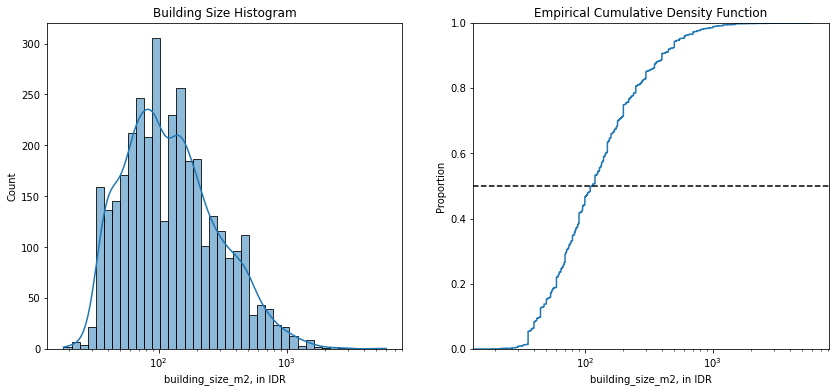

In [46]:
house_df = pd.read_csv('Dataset\jabodetabek_house_data_prcsd.csv')
house_df.loc[house_df.city.str.contains('Jakarta'), 'city'] = ' DKI Jakarta'
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(
    data=house_df, x='building_size_m2', 
    kde=True, ax=ax[0], log_scale=True
    )
sns.ecdfplot(
    data=house_df, x='building_size_m2',ax=ax[1], log_scale=True
)
ax[0].set_title('Building Size Histogram')
ax[1].axhline(y=0.5, ls='--', color='black')
# ax[1].text(x=5*10e6, y=0.52, s=f'Proportion = 0.5,\nMedian={median:,.0f}')
ax[1].set_title('Empirical Cumulative Density Function')
for ax_ in ax:
    ax_.set_xlabel('building_size_m2, in IDR')

In [47]:
house_df[['building_size_m2']].describe(percentiles=[0.25, 0.5, 0.75]).T.rename(columns={'50%': 'median'})

,count,mean,std,min,25%,median,75%,max
building_size_m2,"3,443.00",186.96,249.52,18.00,67.00,113.00,205.00,"6,000.00"


If we interpert 50% percentile as the most popular building size, we found that around 100 m2 is quite popular. Suggested building size range based on above distribution may cover 25% and 75% percentile then:

$$building\;size = [60m^2,\;200m^2]$$

Furthermore, we can possibly inspect the building size pattern for each location using plot below:

(0.0, 400.0)

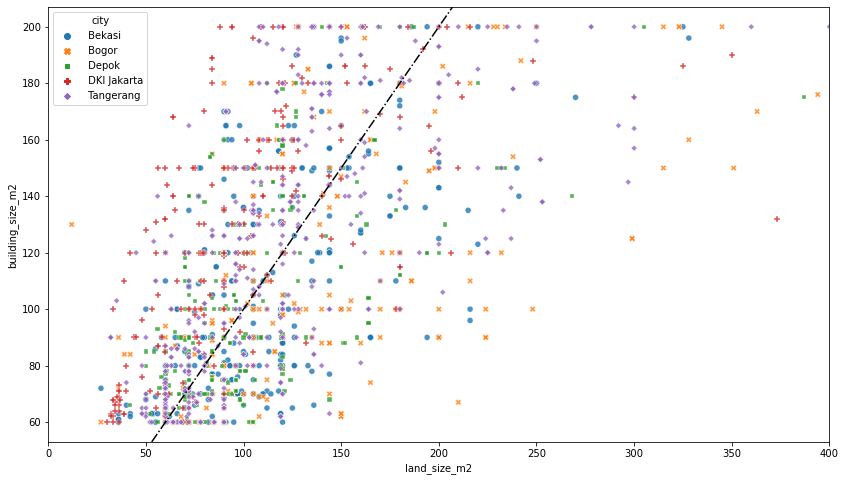

In [48]:
fig, ax = plt.subplots(figsize=(14, 8))
building_size_filter = \
    np.logical_and(
        (house_df.building_size_m2 >= 60),
        (house_df.building_size_m2 <= 200)
        )
sns.scatterplot(
    data=house_df[building_size_filter],
    x='land_size_m2', y='building_size_m2', hue='city', style='city',
    ax=ax, alpha=0.8
)
ax.axline(xy1=(60, 60), xy2=(200, 200), color='black', ls='-.')
ax.set_xlim(0, 400)

Diagonal line with black color represents `building_size = land_size`, so observations that plotted above this line may suggest building with more than 1 floors.

Some distinguishable pattern:
1. Building size < 100 m2 is quite popular in `Tangerang`
2. House that has more than 1 floor is popular in `DKI Jakarta`.
3. Possibly 1 floored house is popular in `Bogor`.

#### **C. Mathematical Problems to Solve**

Production cost of house alone is described as below:

In [49]:
pd.read_excel('Dataset/unit_price.xlsx')

,work_item,variable,price,unit
0,land prep,land_size_m2,1000000,rp/m2
1,"house build, 1 floor",building_size_m2,4500000,rp/m2
2,"house build, 2 floor",building_size_m2,6000000,rp/m2


$$cost\;per\;house\;=\;land\;cost\;\times\;land\;size\;+\;1,000,000\;land\;size\;+\;(3,000,000\;+\;\;1,500,000\;floor)\;building\;size,$$
$$\\floor\;=\;[1,\;2]$$
$$house\;nos.\times\;cost\;per\;house\leq\;15,000,000,000$$

Where land size and building size subjects of each a house to be constructed.

Land price per meter square and the available area are as below:

In [50]:
pd.read_excel('Dataset/land_price.xlsx')

,no,location,city,price_per_m2,available_area_m2
0,1,bogor_1,Bogor,1200000,600
1,2,bogor_2,Bogor,900000,1000
2,3,bogor_3,Bogor,1500000,1200
3,4,bogor_4,Bogor,1000000,800
4,5,bogor_5,Bogor,2000000,500
5,6,depok_1,Depok,800000,2000
6,7,depok_2,Depok,700000,1200
7,8,depok_3,Depok,900000,400
8,9,jakut_1,Jakarta Utara,10000000,600
9,10,jakut_2,Jakarta Utara,8000000,300


$$land\;size\;\times\;house\;nos.\;\leq\;available\;area$$

Following `Designer Division` requirement regarding to land size:

$$land\;size\;\geq1.5\;building\;footprint$$

According to designer specification of first floor (footprint) and second floor (60% of footprint), so:

$$foot\;print=building\;size-(floor-1)\times\;0.6\times\;footprint$$

$$foot\;print=building\;size/(1+0.6(floor-1))$$

#### **D. Solution: Optimization Function**

Let variable of determining price-cost of house production be:

$$x_1=house\;nos.,\;x_2=land\;size,\;x_3\;=building\;size,\;x_4=floor,\;x_5=land\;cost$$

$$x_1\geq\;1$$

$$(x_2\;,x_3,\;x_5)>0$$



$$x_4 = 1\;or\;2$$

and location variable:

$$x_6=Jakarta\;Selatan,\;x_7=Jakarta\;Utara,$$
$$\;x_8=Tangerang,\;x_9=Bogor,\;x_{10}=Depok,\;x_{11}=Bekasi$$
$$x_{6..11} = 0\;or\;1$$

So we re-define the equation of cost to construct house:

$$cost=x_1(x_5\times\;x_2+1,000,000\;x_2+(3,000,000+1,500,000\;x_4)x_3)$$

$$cost=x_1\times\;x_2\times\;x_5+1,000,000\;x_1\times\;x_2+3,000,000\;x_1\times\;x_3+1,500,000\;x_1\times\;x_3\times\;x_4$$

and expected price:

$$price=x_1(1,649,567.09\;x_2+12,138,296.57\;x_3+1,169,842,676.34\;x_6+2,329,503,679.48\;x_7+356,120,481.11\;x_8)$$

so:

$$price=1,649,567.09\;x_1\times\;x_2+12,138,296.57\;x_1\times\;x_3$$
$$+1,169,842,676.34\;x_1\times\;x_6+2,329,503,679.48\;x_1\times\;x_7+356,120,481.11\;x_1\times\;x_8$$

This result in following mathematical problem then,

Find: $$x_1,\;x_2,\;x_3,\;x_4$$


given:
$$x_5,\;x_6,\;x_7,\;x_8$$

that maximize: 
$$y = price(x_1,\;x_2,\;x_3\;x_6,\;x_7,\;x_8) - cost(x_1,\;x_2,\;x_3,\;x_4,\;x_5)$$

or in other form, minimize (to suit with program that using algorithm to minimize cost function):
$$y* = cost(x_1,\;x_2,\;x_3,\;x_4,\;x_5) - price(x_1,\;x_2,\;x_3\;x_6,\;x_7,\;x_8)$$

with constraint:
$$cost(x_1,\;x_2,\;x_3,\;x_4,\;x_5)\leq\;(A=15,000,000,000)$$

$$price(x_1,\;x_2,\;x_3,\;x_4,\;x_5)/x_1\leq\;(B=5,000,000,000)$$

$$x_1\;\times\;x_2\leq\;A,\;where\;C=available\;area$$

$$x_2\;(1+0.6(x_4-1))\;/x_3>1.5$$

$$60\leq\;x_3\leq\;200$$

$$x_{1...5} > 0$$

We iterate along *x<sub>5</sub> (land price)* and its corresponding *A (available area)* to find the maximized profit for that location, then we will compare which has the most profit among others.

So we will create a python function with i/o: 

$$F(x_5, x_6, x_7, x_8, A)\rightarrow(x_1,x_2,x_3,x_4,\;cost,\;mean\;price, \;standard\;deviation\;)$$

Recall that `standard deviation of a distribution` explains *by how much, on average, the observations in that particular distribution differs from its own mean*. We then determine price tag for promotion (slightly lower price) or optimistic profit (slightly higher price), which then we select the price range by -1 to +1 times the standard deviation from mean price. The standard deviation itself will be determined using bootstrapping (i.e. bootstrap standard deviation).

In [205]:
from scipy.optimize import minimize
from scipy.stats import norm
from joblib import load

class OptimizeParameter:
    def __init__(self):
        self._fitted_regressor = load('modules\\fitted_regressor.joblib')
        # # variables to estimate
        # self._x1, self._x2, self._x3, self._x4 = \
        #     [None, None, None, None]
        # # known variable
        # self._x5, self._x6, self._x7, self._x8 =\
        #     [None, None, None, None]
        # # constraint
        # self._A, self._B, self._C =\
        #     [None, None, None]
        # # attributes
        # self.estimated_vars_ = None
        # self.price_ = None
        # self.cost_ = None
        # self.land_area_ = None
    
    @staticmethod
    def _price_func(target_vars, known_vars):
        # params = variable to estimate: x1, x2, x3, x4
        # Unpack params
        x1, x2, x3, x4 = target_vars
        x5, x6, x7, x8, x9, x10, x11 = known_vars
        # Price func
        price = \
            1649567.09 * x1 * x2\
                + 12138296.57 * x1 * x3\
                + 1169842676.34 * x1 * x6\
                + 2329503679.48 * x1 * x7\
                + 356120481.11 * x1 * x8
        return price

    @staticmethod
    def _cost_func(target_vars, known_vars):
        # params = variable to estimate: x1, x2, x3, x4
        # Unpack params
        x1, x2, x3, x4 = target_vars
        x5, x6, x7, x8, x9, x10, x11 = known_vars
        # cost func
        cost = \
            x1 * x2 * x5\
                + 1000000 * x1 * x2\
                + 3000000 * x1 * x3\
                + 1500000 * x1 * x3 * x4
        return cost

    def _obj_func(self, target_vars, known_vars):
        obj = \
            self._cost_func(target_vars, known_vars)\
                - self._price_func(target_vars, known_vars)
        return obj

    def _cost_const(self, target_vars, known_vars, A):
        # type = 'ineq' --> to be non-negative
        return (A - self._cost_func(target_vars, known_vars))
    
    def _x1_roundup_const(self, target_vars, roundup):
        # type = 'ineq' --> to be non-negative
        x1, x2, x3, x4 = target_vars
        # force the roundup value to be the allowed lowest value of x1
        # then try to optimize using x1 > roundup value
        return x1 - roundup
    
    def _x1_rounddown_const(self, target_vars, rounddown):
        # type = 'ineq' --> to be non-negative
        x1, x2, x3, x4 = target_vars
        # allow optimizer to search for x1 below lower bound
        # then try to optimize using x1 < lower bound
        return rounddown - x1

    def _price_const(self, target_vars, known_vars, B):
        # type = 'ineq' --> to be non-negative
        x1, x2, x3, x4 = target_vars
        return (B - (self._price_func(target_vars, known_vars) / x1))

    @staticmethod
    def _house_nos_const(target_vars):
        # type = 'ineq' --> to be non-negative
        x1, x2, x3, x4 = target_vars
        return (x1 - 1) 
 
    @staticmethod
    def _area_const(target_vars, C):
        # type = 'ineq' --> to be non-negative
        x1, x2, x3, x4 = target_vars
        return (C - x1 * x2)

    @staticmethod
    def _footprint_const(target_vars):
        x1, x2, x3, x4 = target_vars
        return (x2 * (1 + 0.6 * (x4 - 1)) / x3 - 1.5)

    @staticmethod
    def _min_build_size_const(target_vars):
        x1, x2, x3, x4 = target_vars
        return (x3 - 60)

    @staticmethod
    def _max_build_size_const(target_vars):
        x1, x2, x3, x4 = target_vars
        return (200 - x3)

    @staticmethod
    def _min_floor_const(target_vars):
        x1, x2, x3, x4 = target_vars
        return (x4 - 1)

    @staticmethod
    def _max_floor_const(target_vars):
        x1, x2, x3, x4 = target_vars
        return (2 - x4)

    @staticmethod
    def _nonzero_const_x1(target_vars):
        x1, x2, x3, x4 = target_vars
        return x1

    @staticmethod
    def _nonzero_const_x2(target_vars):
        x1, x2, x3, x4 = target_vars
        return x2

    @staticmethod
    def _nonzero_const_x3(target_vars):
        x1, x2, x3, x4 = target_vars
        return x3

    @staticmethod
    def _nonzero_const_x4(target_vars):
        x1, x2, x3, x4 = target_vars
        return x4

    def _get_pi(self, x, z, quantile=[0.25, 0.75], confidence_level=None):
        x_point = np.array(x).reshape(1, 5)
        z_point = np.array(z).reshape(1, 2)
        sigma2 = self._fitted_regressor.variance_
        weight = self._fitted_regressor.get_sample_weight(z_point)
        sigma2i = sigma2 * np.power(weight, -1)
        if confidence_level:
            interval = norm.interval(confidence_level)
        else:
            interval = norm.ppf(quantile)
        resid_lower = np.sqrt(sigma2i) * interval[0]
        resid_upper = np.sqrt(sigma2i) * interval[1]
        mean = self._fitted_regressor.predict(x_point)
        pi_low = mean + resid_lower
        pi_high = mean + resid_upper
        return (pi_low, pi_high)

    def _optimizer(self, known_vars, init_guess, constraint_dict):
        result = minimize(
            fun=lambda x: self._obj_func(x, known_vars), 
            x0=init_guess,
            method='COBYLA',
            constraints=constraint_dict,
            options={
                'maxiter':100000,
                'catol': 0.005
                }
            )
        return result

    # def _verify_round_x1(self, known_vars, estimated_vars, x1_, constraint):
    #     x1_down = np.floor(x1_)
    #     x1_up = np.ceil(x1_)
    #     rounded_obj = [0, 0]
    #     i = 0
    #     rounded_results = [True, True]
    #     while rounder_results[0] & rounded_results[1]:
    #     const_down = constraint \
    #         + [{'type': 'ineq', 'fun': lambda x: self._x1_roundup_const(x, x1_down)}]\
    #         + [{'type': 'ineq', 'fun': lambda x: self._x1_rounddown_const(x, x1_down)}]
    #     const_up = constraint \
    #         + [{'type': 'ineq', 'fun': lambda x: self._x1_roundup_const(x, x1_up)}]\
    #         + [{'type': 'ineq', 'fun': lambda x: self._x1_rounddown_const(x, x1_up)}]
    #     rounded_results = [
    #         self._optimizer(known_vars, estimated_vars, const_down),
    #         self._optimizer(known_vars, estimated_vars, const_up)
    #         ]
    #     if rounded_results[0].success:
    #         print(rounded_results[0])
    #         rounded_obj[0] = self._obj_func(rounded_results[0].x, known_vars)
    #     if rounded_results[1].success:
    #         print(rounded_results[1])
    #         rounded_obj[1] = self._obj_func(rounded_results[1].x, known_vars)
    #     return rounded_results[np.argmin(rounded_obj)]

    def _verify_round_x1(self, known_vars, estimated_vars, x1_, constraint):
        i = 0
        rounded_results = [None, None]
        rounded_obj = [0, 0]
        final_results = None
        final_obj = 0
        while (rounded_results[0] != 0) & (rounded_results[1] != 0) & (x1_ > 1):
            x1_down = np.floor(x1_ + i)
            x1_up = np.ceil(x1_ + i)
            const_down = constraint \
                + [{'type': 'ineq', 'fun': lambda x: self._x1_roundup_const(x, x1_down)}]\
                + [{'type': 'ineq', 'fun': lambda x: self._x1_rounddown_const(x, x1_down)}]
            const_up = constraint \
                + [{'type': 'ineq', 'fun': lambda x: self._x1_roundup_const(x, x1_up)}]\
                + [{'type': 'ineq', 'fun': lambda x: self._x1_rounddown_const(x, x1_up)}]
            rounded_results = [
                self._optimizer(known_vars, estimated_vars, const_down),
                self._optimizer(known_vars, estimated_vars, const_up)
                ]
            if rounded_results[0].success:
                rounded_obj[0] = self._obj_func(rounded_results[0].x, known_vars)
            if rounded_results[1].success:
                rounded_obj[1] = self._obj_func(rounded_results[1].x, known_vars)
            results = rounded_results[np.argmin(rounded_obj)]
            if np.argmin(rounded_obj) == 0:
                i -= 1
            else:
                i += 1
            obj = np.min(rounded_obj)
            if obj < final_obj:
                final_obj = obj
                final_results = results
            if not rounded_results[0].success:
                rounded_results[0] = 0
            if not rounded_results[1].success:
                rounded_results[1] = 0
        if final_results:
            return final_results

    def _estimate_vars(self, known_vars, constraint, init_guess):
        """ 
        Estimate x1, x2, x3, x4 parameters.

        Parameters:
        ----------
        known_vars  : array size (n_samples, 1)
                      contains (x5, x6, x7, x8)
        constraint  : array size (n_samples, 1)
                      contains [A, B, C]
        init_guess  : array size (n_samples, 1)
                      Guess value of (x1, x2, x3, x4)
        Returns:
        --------
        Fitted object.
        """
        A, B, C = constraint
        const = [
            {'type': 'ineq', 'fun': lambda x: self._house_nos_const(x)},
            {'type': 'ineq', 'fun': lambda x: self._cost_const(x, known_vars, A)},
            {'type': 'ineq', 'fun': lambda x: self._price_const(x, known_vars, B)},
            {'type': 'ineq', 'fun': lambda x: self._area_const(x, C)},
            {'type': 'ineq', 'fun': lambda x: self._footprint_const(x)},
            {'type': 'ineq', 'fun': lambda x: self._min_build_size_const(x)},
            {'type': 'ineq', 'fun': lambda x: self._max_build_size_const(x)},
            {'type': 'ineq', 'fun': lambda x: self._nonzero_const_x1(x)},
            {'type': 'ineq', 'fun': lambda x: self._nonzero_const_x2(x)},
            {'type': 'ineq', 'fun': lambda x: self._nonzero_const_x3(x)},
            {'type': 'ineq', 'fun': lambda x: self._nonzero_const_x4(x)},
            {'type': 'ineq', 'fun': lambda x: self._min_floor_const(x)},
            {'type': 'ineq', 'fun': lambda x: self._max_floor_const(x)},
            ]
        result = self._optimizer(known_vars, init_guess, const)
        if result.success:
            estimated_vars = result.x
        else:
            print(f'Optimization Error for {known_vars}:\n{ValueError(result.message)}')
            print(result)
        obj = self._obj_func(estimated_vars, known_vars)
        # initiate rounding estimate
        upd_result = self._verify_round_x1(
            known_vars, estimated_vars, 
            estimated_vars[0], const
            )
        if upd_result:
            result = upd_result
        estimated_vars = result.x
        # calculate prediction interval
        x1, x2, x3, x4 = estimated_vars
        x5, x6, x7, x8 = known_vars[0:4]
        pi = self._get_pi(
            x=[x6, x7, x8, x2, x3],
            z=[x2, x3]
            )
        # final result
        price = self._price_func(estimated_vars, known_vars)
        cost = self._cost_func(estimated_vars, known_vars)
        land_area = -(self._area_const(estimated_vars, 0))
        cost_per_house = cost / x1
        price_per_house = price / x1
        profit = price - cost
        pi_low = pi[0]
        pi_upper = pi[1]
        summary =  np.array([
            x1, x2, x3, x4, land_area,
            cost, cost_per_house,
            price, price_per_house,
            pi_low, pi_upper, profit
            ], dtype='object').reshape(1, 12)
        return summary

    def get_estimated_vars(
            self, known_vars, constraint, 
            init_guess, to_dataframe=True):
        """ 
        Estimate x1, x2, x3, x4 parameters.

        Parameters:
        ----------
        known_vars  : Array size (n_samples, 7)
                      contains (x5, x6, x7, x8, x9, x10, x11)
        constraint  : Array size (n_samples, 3)
                      or (1, 3) (broadcast to all samples)
                      contains [A, B, C]
        init_guess  : Array size (n_samples, 4)
                      or (1, 4) (broadcast to all samples)
                      Guess value of (x1, x2, x3, x4)
        Returns:
        --------
        Estimated parameters: DataFrame or array-like size (n_samples, 4)
        """
        if known_vars.shape[0] == constraint.shape[0]:
            params = np.c_[known_vars, constraint]
        else:
            params = np.c_[
                known_vars,
                np.broadcast_to(
                    constraint, (known_vars.shape[0], 3)
                    )
            ]
        if known_vars.shape[0] == init_guess.shape[0]:
            params = np.c_[params, init_guess]
        else:
            params = np.c_[
                params,
                np.broadcast_to(
                    init_guess, (known_vars.shape[0], 4)
                    )
            ]
        # Optimization Result.
        optimization_result = np.zeros((params.shape[0], 12))
        for i, param in enumerate(params):
            known_vars_ = param[:7]
            constraints_ = param[7:10]
            init_guess_ = param[10:14]
            result = self._estimate_vars(
                list(known_vars_), list(constraints_), list(init_guess_)
                )
            optimization_result[i, :] = result
        columns = [
            'house_nos.', 'house_land_size_m2', 'house_size_m2',
            'floor_nos', 'total_land_area', 'total_cost',
            'cost_per_house', 'total_price', 'house_price',
            'house_price_lower', 'house_price_upper','total_profit'
            ]
        if to_dataframe:
            return (pd.DataFrame(
                optimization_result, columns=columns, index=[0]
                )
            )
        return optimization_result

known_vars = np.array([1500000, 0, 0, 1, 0, 0, 0]).reshape(1, 7)
constraint = np.array([15000000000, 5000000000, 1500]).reshape(1, 3)
init_guess = np.array([5, 100, 60, 1]).reshape(1, 4)
estimator = OptimizeParameter()
results = estimator.get_estimated_vars(known_vars, constraint, init_guess)
results

,house_nos.,house_land_size_m2,house_size_m2,floor_nos,total_land_area,total_cost,cost_per_house,total_price,house_price,house_price_lower,house_price_upper,total_profit
0,26.00,57.69,61.54,2.00,"1,500.00","13,350,000,025.36","513,461,539.44","31,154,757,707.16","1,198,259,911.81","930,426,515.01","1,466,093,308.05","17,804,757,681.80"


In [206]:
pd.read_excel('Dataset/land_price.xlsx')

,no,location,city,price_per_m2,available_area_m2
0,1,bogor_1,Bogor,1200000,600
1,2,bogor_2,Bogor,900000,1000
2,3,bogor_3,Bogor,1500000,1200
3,4,bogor_4,Bogor,1000000,800
4,5,bogor_5,Bogor,2000000,500
5,6,depok_1,Depok,800000,2000
6,7,depok_2,Depok,700000,1200
7,8,depok_3,Depok,900000,400
8,9,jakut_1,Jakarta Utara,10000000,600
9,10,jakut_2,Jakarta Utara,8000000,300


In [209]:
land_price_df = pd.read_excel('Dataset/land_price.xlsx')
land_price_df.assign(
    x5 = land_price_df.price_per_m2,
    x6 = lambda x: 1 if (land_price_df.city == 'Jakarta Selatan') else 0
)
land_price_df

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

$$x_1=house\;nos.,\;x_2=land\;size,\;x_3\;=building\;size,\;x_4=floor,\;x_5=land\;cost$$

$$x_1\geq\;1$$

$$(x_2\;,x_3,\;x_5)>0$$



$$x_4 = 1\;or\;2$$

$$x_6=Jakarta\;Selatan,\;x_7=Jakarta\;Utara,$$
$$\;x_8=Tangerang,\;x_9=Bogor,\;x_{10}=Depok,\;x_{11}=Bekasi$$
$$x_{6..11} = 0\;or\;1$$

In [211]:
class Burung:
    def __init__(self, nama):
        self.nama = nama

class Ayam(Burung):
    pass

tes = Ayam('jeruk')
tes.nama

'jeruk'

In [145]:
# from scipy.optimize import minimize

# class OptimizeParameter:
#     def __init__(self):
#         # initial guess
#         self.x1_, self.x2_, self.x3_, self.x4_ = \
#             [None, None, None, None]
#         # known variable
#         self.x5, self.x6, self.x7, self.x8 =\
#             [None, None, None, None]
#         # constraint
#         self.A, self.B, self.C =\
#             [None, None, None]
#         # attributes
#         self.estimated_vars_ = None
#         self.price_ = None
#         self.cost_ = None
#         self.land_area_ = None
    
#     @staticmethod
#     def _price_func(target_vars, known_vars):
#         # params = variable to estimate: x1, x2, x3, x4
#         # Unpack params
#         x1, x2, x3, x4 = target_vars
#         x5, x6, x7, x8, x9, x10, x11 = known_vars
#         # Price func
#         price = \
#             1649567.09 * x1 * x2\
#                 + 12138296.57 * x1 * x3\
#                 + 1169842676.34 * x1 * x6\
#                 + 2329503679.48 * x1 * x7\
#                 + 356120481.11 * x1 * x8
#         return price

#     @staticmethod
#     def _cost_func(target_vars, known_vars):
#         # params = variable to estimate: x1, x2, x3, x4
#         # Unpack params
#         x1, x2, x3, x4 = target_vars
#         x5, x6, x7, x8, x9, x10, x11 = known_vars
#         # cost func
#         cost = \
#             x1 * x2 * x5\
#                 + 1000000 * x1 * x2\
#                 + 3000000 * x1 * x3\
#                 + 1500000 * x1 * x3 * x4
#         return cost

#     def _obj_func(self, target_vars, known_vars):
#         obj = \
#             self._cost_func(target_vars, known_vars)\
#                 - self._price_func(target_vars, known_vars)
#         return obj

#     def _cost_const(self, target_vars, known_vars, A):
#         # type = 'ineq' --> to be non-negative
#         return (A - self._cost_func(target_vars, known_vars))
    
#     def _x1_roundup_const(self, target_vars, roundup):
#         # type = 'ineq' --> to be non-negative
#         x1, x2, x3, x4 = target_vars
#         # force the roundup value to be the allowed lowest value of x1
#         # then try to optimize using x1 > roundup value
#         return x1 - roundup
    
#     def _x1_rounddown_const(self, target_vars, rounddown):
#         # type = 'ineq' --> to be non-negative
#         x1, x2, x3, x4 = target_vars
#         # allow optimizer to search for x1 below lower bound
#         # then try to optimize using x1 < lower bound
#         return rounddown - x1

#     def _price_const(self, target_vars, known_vars, B):
#         # type = 'ineq' --> to be non-negative
#         x1, x2, x3, x4 = target_vars
#         return (B - (self._price_func(target_vars, known_vars) / x1))

#     @staticmethod
#     def _house_nos_const(target_vars):
#         # type = 'ineq' --> to be non-negative
#         x1, x2, x3, x4 = target_vars
#         return (x1 - 1) 
 
#     @staticmethod
#     def _area_const(target_vars, C):
#         # type = 'ineq' --> to be non-negative
#         x1, x2, x3, x4 = target_vars
#         return (C - x1 * x2)

#     @staticmethod
#     def _footprint_const(target_vars):
#         x1, x2, x3, x4 = target_vars
#         return (x2 * (1 + 0.6 * (x4 - 1)) / x3 - 1.5)

#     @staticmethod
#     def _min_build_size_const(target_vars):
#         x1, x2, x3, x4 = target_vars
#         return (x3 - 60)

#     @staticmethod
#     def _max_build_size_const(target_vars):
#         x1, x2, x3, x4 = target_vars
#         return (200 - x3)

#     @staticmethod
#     def _min_floor_const(target_vars):
#         x1, x2, x3, x4 = target_vars
#         return (x4 - 1)

#     @staticmethod
#     def _max_floor_const(target_vars):
#         x1, x2, x3, x4 = target_vars
#         return (2 - x4)

#     @staticmethod
#     def _nonzero_const_x1(target_vars):
#         x1, x2, x3, x4 = target_vars
#         return x1

#     @staticmethod
#     def _nonzero_const_x2(target_vars):
#         x1, x2, x3, x4 = target_vars
#         return x2

#     @staticmethod
#     def _nonzero_const_x3(target_vars):
#         x1, x2, x3, x4 = target_vars
#         return x3

#     @staticmethod
#     def _nonzero_const_x4(target_vars):
#         x1, x2, x3, x4 = target_vars
#         return x4

#     def _bootstrap_price(self):
#         # tbd
#         pass

#     def _optimizer(self, known_vars, init_guess, constraint_dict):
#         result = minimize(
#             fun=lambda x: self._obj_func(x, known_vars), 
#             x0=init_guess,
#             method='COBYLA',
#             constraints=constraint_dict)
#         return result

#     def _verify_round_x1(self, estimated_vars, x1_):
#         x1_down = np.floor(x1_)
#         x1_up = np.ceil(x1_)
#         rounded_price = [0, 0]
#         const_down = self._const \
#             + [{'type': 'ineq', 'fun': lambda x: self._x1_rounddown_const(x, x1_down)}]
#         const_up = self._const \
#             + [{'type': 'ineq', 'fun': lambda x: self._x1_roundup_const(x, x1_up)}]
#         rounded_results = [
#             self._optimizer(self._known_vars, estimated_vars, const_down),
#             self._optimizer(self._known_vars, estimated_vars, const_up)
#         ]
#         if rounded_results[0].success:
#             rounded_price[0] = self._price_func(rounded_results[0].x, self._known_vars)
#         if rounded_results[1].success:
#             rounded_price[1] = self._price_func(rounded_results[1].x, self._known_vars)
#         return rounded_results[np.argmax(rounded_price)]

#     def estimate_parameter(self, known_vars, constraint, init_guess):
#         """ 
#         Estimate parameters.

#         Parameters:
#         ----------
#         known_vars  : list with length = 4
#                       [x5, x6, x7, x8]
#         constraint  : list with length = 3
#                       [A, B, C]
#         init_guess  : list with length = 4
#                       Guess value of x1, x2, x3, x4
#                       [x1, x2, x3, x4]
        
#         Returns:
#         --------
#         OptimizeParameter(): Fitted OptimizeParameter=Object
#         """
#         self.A, self.B, self.C = constraint
#         self._known_vars = known_vars.copy()
#         self._init_guess = init_guess.copy()
#         self._const = [
#             {'type': 'ineq', 'fun': lambda x: self._house_nos_const(x)},
#             {'type': 'ineq', 'fun': lambda x: self._cost_const(x, known_vars, self.A)},
#             {'type': 'ineq', 'fun': lambda x: self._price_const(x, known_vars, self.B)},
#             {'type': 'ineq', 'fun': lambda x: self._area_const(x, self.C)},
#             {'type': 'ineq', 'fun': lambda x: self._footprint_const(x)},
#             {'type': 'ineq', 'fun': lambda x: self._min_build_size_const(x)},
#             {'type': 'ineq', 'fun': lambda x: self._max_build_size_const(x)},
#             {'type': 'ineq', 'fun': lambda x: self._nonzero_const_x1(x)},
#             {'type': 'ineq', 'fun': lambda x: self._nonzero_const_x2(x)},
#             {'type': 'ineq', 'fun': lambda x: self._nonzero_const_x3(x)},
#             {'type': 'ineq', 'fun': lambda x: self._nonzero_const_x4(x)},
#             {'type': 'ineq', 'fun': lambda x: self._min_floor_const(x)},
#             {'type': 'ineq', 'fun': lambda x: self._max_floor_const(x)},
#         ]
#         result = self._optimizer(self._known_vars, self._init_guess, self._const)
#         if result.success:
#             self.x1_, self.x2_, self.x3_, self.x4_ = result.x
#             self.estimated_vars_ = result.x
#         else:
#             raise ValueError(result.message)
#         # initiate rounding estimate
#         result = self._verify_round_x1(self.estimated_vars_, self.x1_)
#         self.x1_, self.x2_, self.x3_, self.x4_ = result.x
#         self.estimated_vars_ = result.x
#         self.price_ = self._price_func(self.estimated_vars_, self._known_vars)
#         self.cost_ = self._cost_func(self.estimated_vars_, self._known_vars)
#         self.land_area_ = -(self._area_const(self.estimated_vars_, 0))
#         return self

# known_vars = [8000000, 0, 0, 1, 0, 0, 0]
# constraint = [20000000000, 5000000000, 1500]
# init_guess = [5, 100, 60, 1]
# estimator = OptimizeParameter()
# fitted_estimator = estimator.estimate_parameter(known_vars, constraint, init_guess)
# fitted_estimator.estimated_vars_

array([23.        , 56.25000017, 60.        ,  2.        ])

In [107]:
norm.ppf([0.25, 0.75])

array([-0.67448975,  0.67448975])

In [113]:
np.where(np.array([1b, 2, 3, 4]).reshape(1, 4))[0]

array([0, 0, 0, 0], dtype=int64)

In [73]:
a = np.array([1, 2, 3, 4])
b = np.array([5, 6, 7])

np.r_[a, b]

array([1, 2, 3, 4, 5, 6, 7])

In [94]:
a, b, c = [1, 2, 3, 4, 5, 6]
a, b, c

ValueError: too many values to unpack (expected 3)

In [89]:
list(np.array([1, 2, 3]))

[1, 2, 3]

In [75]:
a = np.array([[1, 2, 3], ['a', 'b', 'c']])

a[1] = [4, 5, 6]

a

array([['1', '2', '3'],
       ['4', '5', '6']], dtype='<U11')

In [56]:
for value in np.array([[1,2], [3, 4]]):
    print(value)
    break

[1 2]


In [ ]:
pd.DataFrame(
    coef_array,
    columns=['features_name', 'coef', 'conf_low', 'conf_high']
    ).set_index('features_name')

,coef,conf_low,conf_high
features_name,,,
C(city)[ Jakarta Selatan],"1,169,842,676.34","-1,679,058,494.03","4,033,328,861.43"
C(city)[ Jakarta Utara],"2,329,503,679.48","-752,284,729.46","5,398,464,885.95"
C(city)[ Tangerang],"356,120,481.11","-587,590,298.51","1,290,177,536.72"
land_size_m2,"1,649,567.09","-1,733,939.29","5,050,964.54"
building_size_m2,"12,138,296.57","7,582,893.27","16,750,337.40"
